In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy

from pyproj import Transformer   # <– new for coordinate system test

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120

In [2]:
# =============================================================================
# 1. CONFIG: file names and experiments to fix
# =============================================================================

files_vcog = {
    "Exp_1": "Exp_1_VCoG_TOC.csv",
    "Exp_2": "Exp_2_VCoG_TOC_EW.csv",
    "Exp_3": "Exp_3_VCoG_2m_OL_Ncable_WE.csv",
    "Exp_4": "Exp_4_VCoG_4m_OL_Ncable_EW.csv",
    "Exp_5": "Exp_5_VCoG_6m_OL_Ncable_WE.csv",
}

files_ccog = {
    "Exp_1": "Exp_1_CCoG_TOC.csv",
    "Exp_2": "Exp_2_CCoG_TOC_EW.csv",
    "Exp_3": "Exp_3_CCoG_2m_OL_Ncable_WE.csv",
    "Exp_4": "Exp_4_CCoG_4m_OL_Ncable_EW.csv",
    "Exp_5": "Exp_5_CCoG_6m_OL_Ncable_WE.csv",
}

# experiments where heading / cable coords should be fixed via 180° flip
EXPERIMENTS_TO_FIX = ["Exp_1", "Exp_2"]

# =============================================================================
# 2. LOAD ALL RAW FILES
# =============================================================================

vcog_raw = {}
ccog_raw = {}

for exp in files_vcog:
    v_path = files_vcog[exp]
    c_path = files_ccog[exp]

    if not os.path.exists(v_path):
        raise FileNotFoundError(f"Missing VCOG file for {exp}: {v_path}")
    if not os.path.exists(c_path):
        raise FileNotFoundError(f"Missing CCOG file for {exp}: {c_path}")

    vcog_raw[exp] = pd.read_csv(v_path, header=None)
    ccog_raw[exp] = pd.read_csv(c_path, header=None)

print("Loaded experiments:", list(vcog_raw.keys()))

Loaded experiments: ['Exp_1', 'Exp_2', 'Exp_3', 'Exp_4', 'Exp_5']


Exp_2 – first 5 values of time columns:
   unix_time_col0  hhmmss_col1
0    1.759746e+09   121557.031
1    1.759746e+09   121557.235
2    1.759746e+09   121557.451
3    1.759746e+09   121557.655
4    1.759746e+09   121557.857


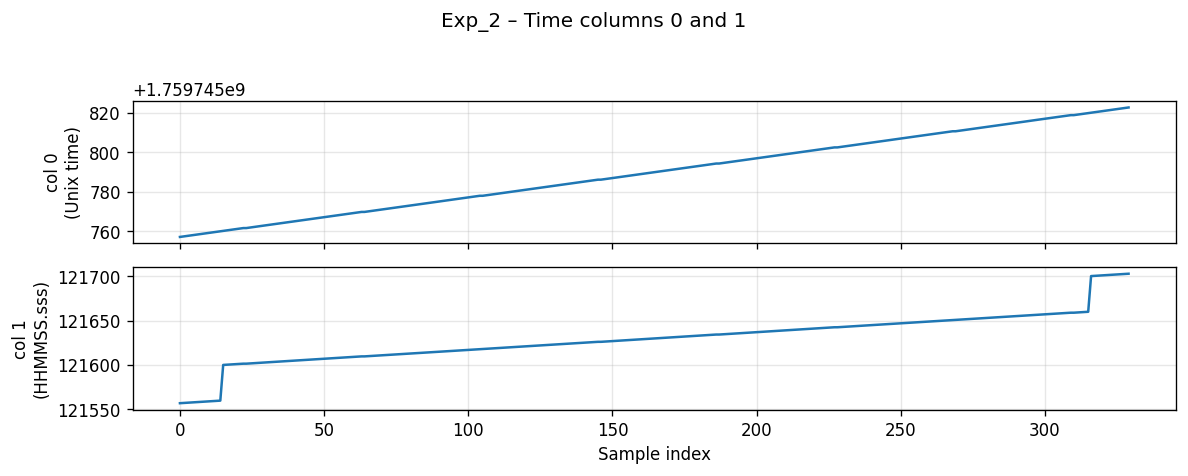

In [3]:
# =============================================================================
# 2A. COLUMN IDENTIFICATION – TIME (cols 0 and 1)
# =============================================================================

example_exp = "Exp_2"   # representative experiment
v = vcog_raw[example_exp]

col0 = v.iloc[:, 0]  # Unix time
col1 = v.iloc[:, 1]  # HHMMSS.sss

print(f"{example_exp} – first 5 values of time columns:")
print(pd.DataFrame({
    "unix_time_col0": col0.head(),
    "hhmmss_col1": col1.head()
}))

# Quick plot: both columns vs sample index
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax[0].plot(col0.values)
ax[0].set_ylabel("col 0\n(Unix time)")
ax[0].grid(True, alpha=0.3)

ax[1].plot(col1.values)
ax[1].set_ylabel("col 1\n(HHMMSS.sss)")
ax[1].set_xlabel("Sample index")
ax[1].grid(True, alpha=0.3)

fig.suptitle(f"{example_exp} – Time columns 0 and 1")
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [4]:
# =============================================================================
# 2B. COLUMN IDENTIFICATION – WORLD COORDINATES (cols 2,3,4)
# =============================================================================

# Spaarnwoude lat/lon from the email
lat_sp = 52.4046
lon_sp = 4.6945

# Candidate CRS codes we tested
candidates = [32631, 32632, 3043, 3044, 28992]

print("Transforming Spaarnwoude lat/lon into several candidate CRSs:\n")
for epsg in candidates:
    tr = Transformer.from_crs("epsg:4326", f"epsg:{epsg}", always_xy=True)
    E, N = tr.transform(lon_sp, lat_sp)  # (lon, lat) → (E, N)
    print(f"EPSG:{epsg:<5} -> E={E:10.3f}, N={N:10.3f}")

# Compare one candidate (e.g. 32631) with actual data means
exp_example = "Exp_2"
v = vcog_raw[exp_example]

mean_x = v.iloc[:, 2].mean()
mean_y = v.iloc[:, 3].mean()

print(f"\nMean world coords in {exp_example} (VCoG col2/3):")
print(f"  X ≈ {mean_x:.3f}")
print(f"  Y ≈ {mean_y:.3f}")

print("\nYou can see EPSG:32631 E/N are in the same numeric range,")
print("so we interpret col2, col3 as UTM31N Easting/Northing,")
print("and col4 as height (Netherlands vertical datum).")

Transforming Spaarnwoude lat/lon into several candidate CRSs:

EPSG:32631 -> E=615272.398, N=5807391.296
EPSG:32632 -> E=207167.675, N=5814765.395
EPSG:3043  -> E=615272.398, N=5807391.296
EPSG:3044  -> E=207167.675, N=5814765.395
EPSG:28992 -> E=107861.020, N=490977.347

Mean world coords in Exp_2 (VCoG col2/3):
  X ≈ 619487.736
  Y ≈ 5806174.972

You can see EPSG:32631 E/N are in the same numeric range,
so we interpret col2, col3 as UTM31N Easting/Northing,
and col4 as height (Netherlands vertical datum).


Heading ranges per experiment (VCoG column 5, in degrees):

Exp_1: min=-177.7°, max= 179.3°, mean= -12.8°
Exp_2: min= -94.8°, max= -77.8°, mean= -87.0°
Exp_3: min=  80.7°, max= 108.5°, mean=  94.1°
Exp_4: min= -98.3°, max= -70.4°, mean= -85.5°
Exp_5: min=  83.2°, max= 105.4°, mean=  94.7°


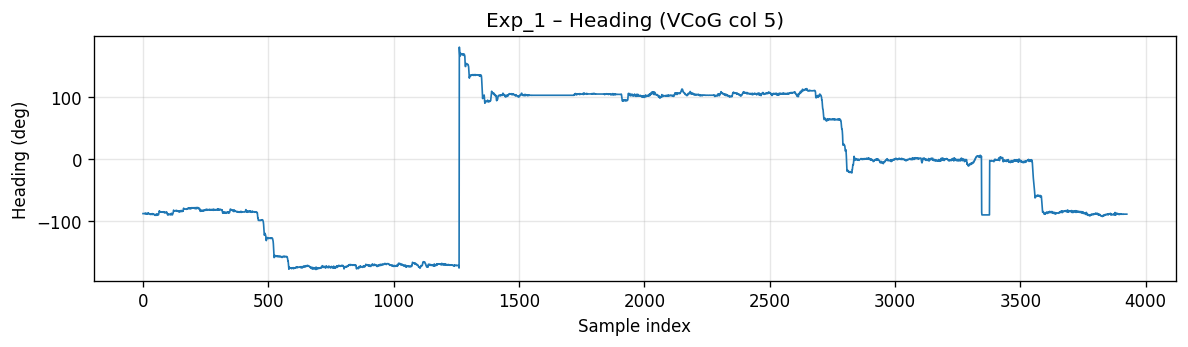

In [5]:
# =============================================================================
# 2C. COLUMN IDENTIFICATION – HEADING (VCoG col 5)
# =============================================================================

print("Heading ranges per experiment (VCoG column 5, in degrees):\n")
for exp, df in vcog_raw.items():
    heading = df.iloc[:, 5]
    print(
        f"{exp}: min={heading.min():6.1f}°, "
        f"max={heading.max():6.1f}°, "
        f"mean={heading.mean():6.1f}°"
    )

# Quick heading plot for Exp_1 to show the full loop effect
exp_h = "Exp_1"
h = vcog_raw[exp_h].iloc[:, 5].values

plt.figure(figsize=(10, 3))
plt.plot(h, linewidth=1.0)
plt.title(f"{exp_h} – Heading (VCoG col 5)")
plt.xlabel("Sample index")
plt.ylabel("Heading (deg)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Exp_2 – correlations:
  corr(dy, CCoG col5) = 0.940
  corr(dz, CCoG col7) = 0.966


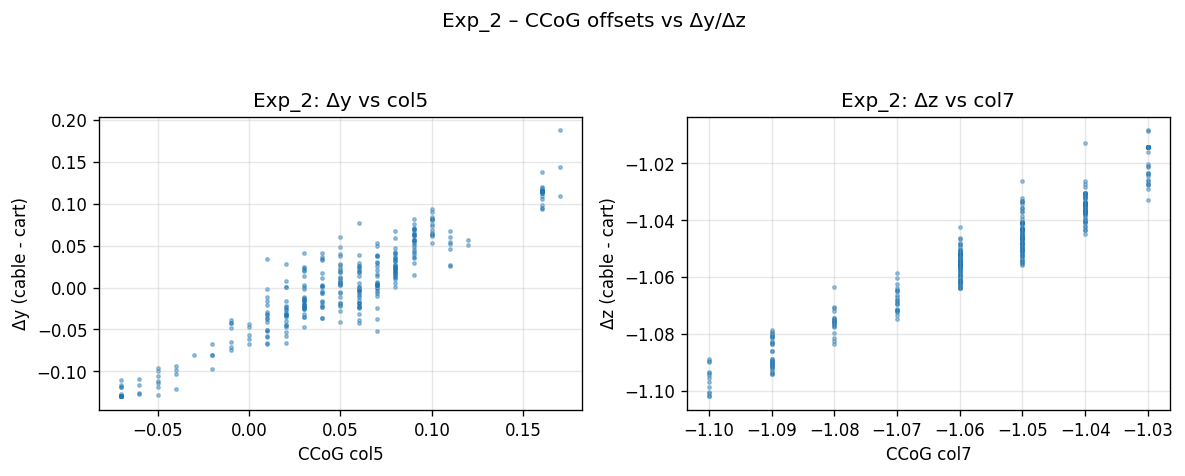


Exp_3 – correlations:
  corr(dy, CCoG col5) = -0.997
  corr(dz, CCoG col7) = 0.999


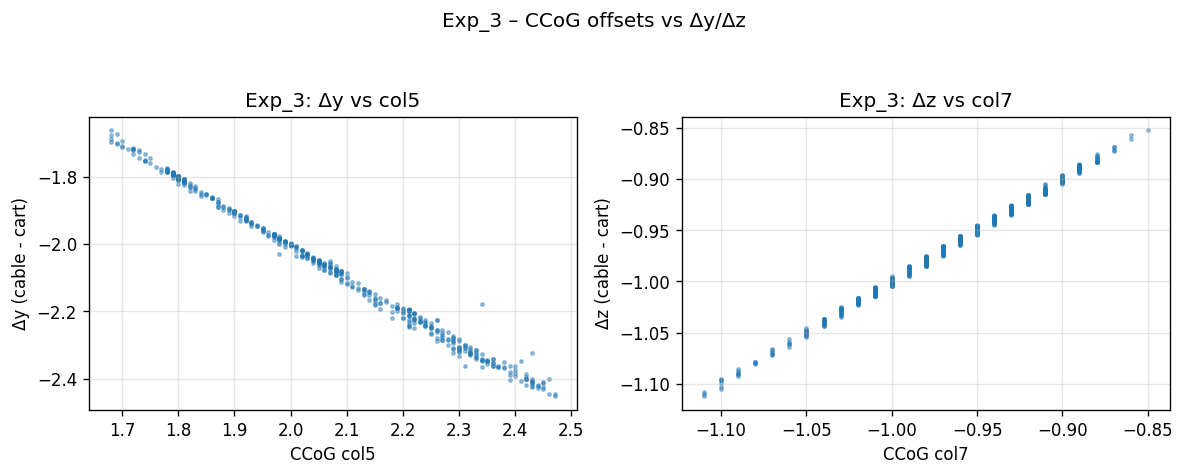


Exp_4 – correlations:
  corr(dy, CCoG col5) = 0.998
  corr(dz, CCoG col7) = 1.000


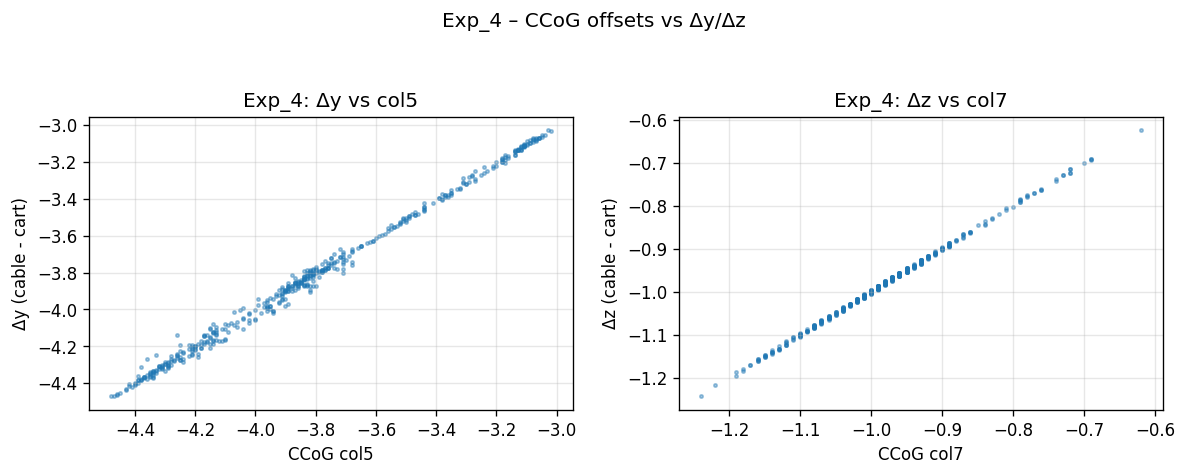


Exp_5 – correlations:
  corr(dy, CCoG col5) = -0.971
  corr(dz, CCoG col7) = 1.000


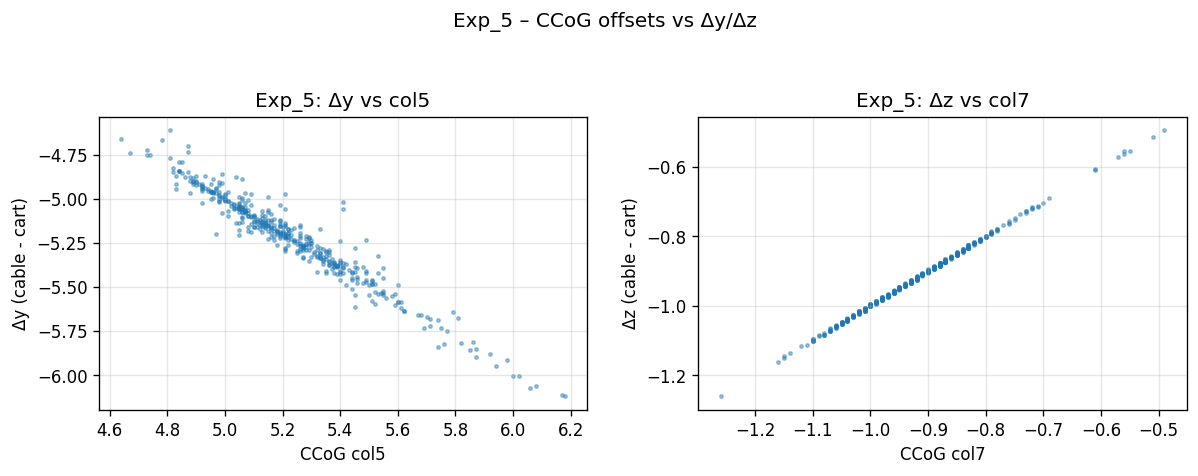

In [6]:
# =============================================================================
# 2D. COLUMN IDENTIFICATION – CCoG offsets vs Δy and Δz
# =============================================================================

def analyze_ccog_offsets(exp):
    """
    For a given experiment:
    - compute Δx, Δy, Δz between cable (CCoG col2/3/4) and cart (VCoG col2/3/4)
    - compute correlation with CCoG columns 5 and 7
    - show scatter plots
    """
    v = vcog_raw[exp]
    c = ccog_raw[exp]

    # keep only rows with good flags, to avoid crazy outliers
    good_mask = (v.iloc[:, -1] != 0) & (c.iloc[:, -1] != 0)
    v = v[good_mask].reset_index(drop=True)
    c = c[good_mask].reset_index(drop=True)

    # world coordinates
    x_cart = v.iloc[:, 2]
    y_cart = v.iloc[:, 3]
    z_cart = v.iloc[:, 4]

    x_cab = c.iloc[:, 2]
    y_cab = c.iloc[:, 3]
    z_cab = c.iloc[:, 4]

    dx = x_cab - x_cart
    dy = y_cab - y_cart
    dz = z_cab - z_cart

    off_y = c.iloc[:, 5]   # candidate lateral offset
    off_z = c.iloc[:, 7]   # candidate vertical offset

    corr_dy_offy = np.corrcoef(dy, off_y)[0, 1]
    corr_dz_offz = np.corrcoef(dz, off_z)[0, 1]

    print(f"\n{exp} – correlations:")
    print(f"  corr(dy, CCoG col5) = {corr_dy_offy:.3f}")
    print(f"  corr(dz, CCoG col7) = {corr_dz_offz:.3f}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(off_y, dy, s=4, alpha=0.4)
    axes[0].set_xlabel("CCoG col5")
    axes[0].set_ylabel("Δy (cable - cart)")
    axes[0].set_title(f"{exp}: Δy vs col5")

    axes[1].scatter(off_z, dz, s=4, alpha=0.4)
    axes[1].set_xlabel("CCoG col7")
    axes[1].set_ylabel("Δz (cable - cart)")
    axes[1].set_title(f"{exp}: Δz vs col7")

    for ax in axes:
        ax.grid(True, alpha=0.3)

    fig.suptitle(f"{exp} – CCoG offsets vs Δy/Δz")
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# Run this for the "good" experiments where the offsets are meaningful
for exp in ["Exp_2", "Exp_3", "Exp_4", "Exp_5"]:
    analyze_ccog_offsets(exp)

In [7]:
# =============================================================================
# 3. CLEAN: remove rows with flag == 0, keep alignment
#     - last column in both VCOG & CCOG is the quality flag
# =============================================================================

vcog_clean = {}
ccog_clean = {}

for exp in vcog_raw:
    v = vcog_raw[exp]
    c = ccog_raw[exp]

    # use combined mask to be extra safe (though we know flags match)
    good_mask = (v.iloc[:, -1] != 0) & (c.iloc[:, -1] != 0)

    v_cl = v[good_mask].reset_index(drop=True)
    c_cl = c[good_mask].reset_index(drop=True)

    vcog_clean[exp] = v_cl
    ccog_clean[exp] = c_cl

    print(
        f"{exp}: kept {len(v_cl)} / {len(v)} rows "
        f"({len(v_cl)/len(v)*100:.1f}% good)"
    )

Exp_1: kept 3878 / 3926 rows (98.8% good)
Exp_2: kept 330 / 330 rows (100.0% good)
Exp_3: kept 503 / 506 rows (99.4% good)
Exp_4: kept 459 / 459 rows (100.0% good)
Exp_5: kept 427 / 427 rows (100.0% good)


In [8]:
# =============================================================================
# 4. HEADING / CABLE COORDS FIX:
#    reflect cable around cart for Exp 1 & 2
#
#    We trust cart coords (VCOG cols 2–4).
#    Wrong cable coords are CCOG cols 2–4.
#
#    Define dx = x_wrong - x_cart, etc.
#    True cable must be on the opposite side of cart:
#
#       x_true = 2*x_cart - x_wrong
#       y_true = 2*y_cart - y_wrong
#       z_true = z_wrong   (180° yaw doesn't affect height)
# =============================================================================

ccog_fixed = {}

for exp in vcog_clean:
    v = vcog_clean[exp].copy()
    c = ccog_clean[exp].copy()

    if exp in EXPERIMENTS_TO_FIX:
        # cart world coords
        x_cart = v.iloc[:, 2]
        y_cart = v.iloc[:, 3]
        z_cart = v.iloc[:, 4]   # not used in fix, but here if needed

        # wrong cable world coords
        x_wrong = c.iloc[:, 2]
        y_wrong = c.iloc[:, 3]
        z_wrong = c.iloc[:, 4]

        # apply reflection correction
        x_true = 2.0 * x_cart - x_wrong
        y_true = 2.0 * y_cart - y_wrong
        z_true = z_wrong  # unchanged

        c_fixed = c.copy()
        c_fixed.iloc[:, 2] = x_true
        c_fixed.iloc[:, 3] = y_true
        c_fixed.iloc[:, 4] = z_true

        ccog_fixed[exp] = c_fixed
        print(f"{exp}: applied 180° cable reflection fix.")
    else:
        # unchanged for good experiments
        ccog_fixed[exp] = c.copy()
        print(f"{exp}: left cable coords unchanged (already good).")

Exp_1: applied 180° cable reflection fix.
Exp_2: applied 180° cable reflection fix.
Exp_3: left cable coords unchanged (already good).
Exp_4: left cable coords unchanged (already good).
Exp_5: left cable coords unchanged (already good).


In [9]:
# =============================================================================
# 5. DIRECTION NORMALIZATION (for plotting)
#    - use Exp_3 as reference (good, stable line)
#    - work with FIXED CCOG (so Exp_1 & 2 are corrected)
# =============================================================================

def normalize_direction(xy, ref_xy):
    """
    Reverse order of xy if its direction is opposite to ref_xy.
    xy and ref_xy are arrays of shape (N, 2) for (X,Y).
    """
    d_df  = xy[-1]  - xy[0]
    d_ref = ref_xy[-1] - ref_xy[0]
    cos = np.dot(d_df, d_ref) / (np.linalg.norm(d_df) * np.linalg.norm(d_ref))
    if cos < 0:
        return xy[::-1]
    else:
        return xy

# reference XY from Exp_3 (fixed == original here)
ref_xy = ccog_fixed["Exp_3"].iloc[:, 2:4].values

norm_xy_fixed = {}
for exp, c in ccog_fixed.items():
    xy = c.iloc[:, 2:4].values
    norm_xy_fixed[exp] = normalize_direction(xy, ref_xy)

# Also build the "original" normalized XY (for before/after comparison)
norm_xy_original = {}
for exp, c in ccog_clean.items():
    xy = c.iloc[:, 2:4].values
    norm_xy_original[exp] = normalize_direction(xy, ref_xy)

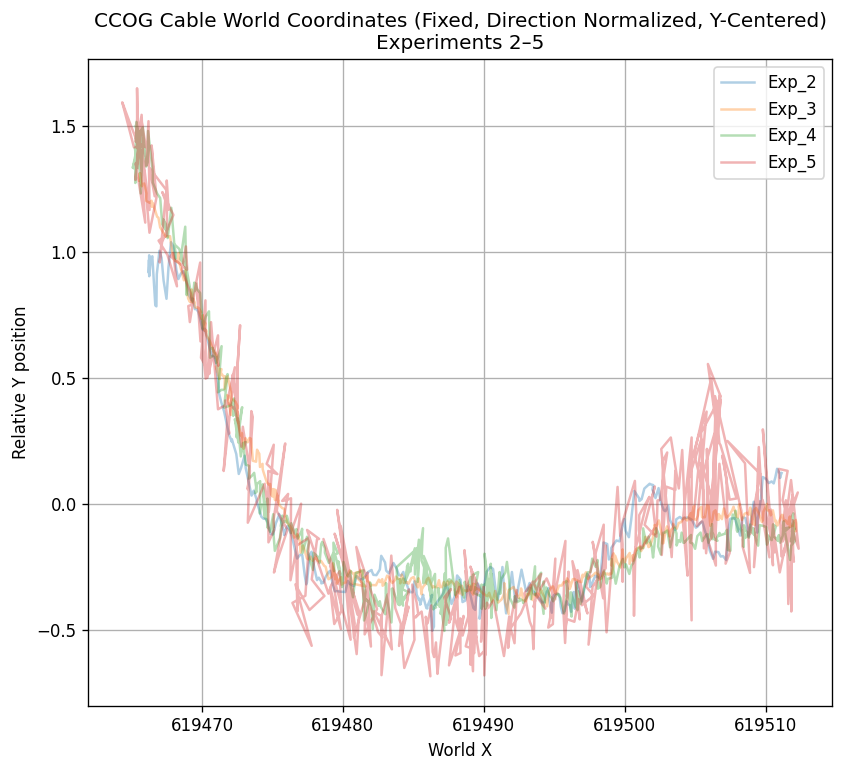

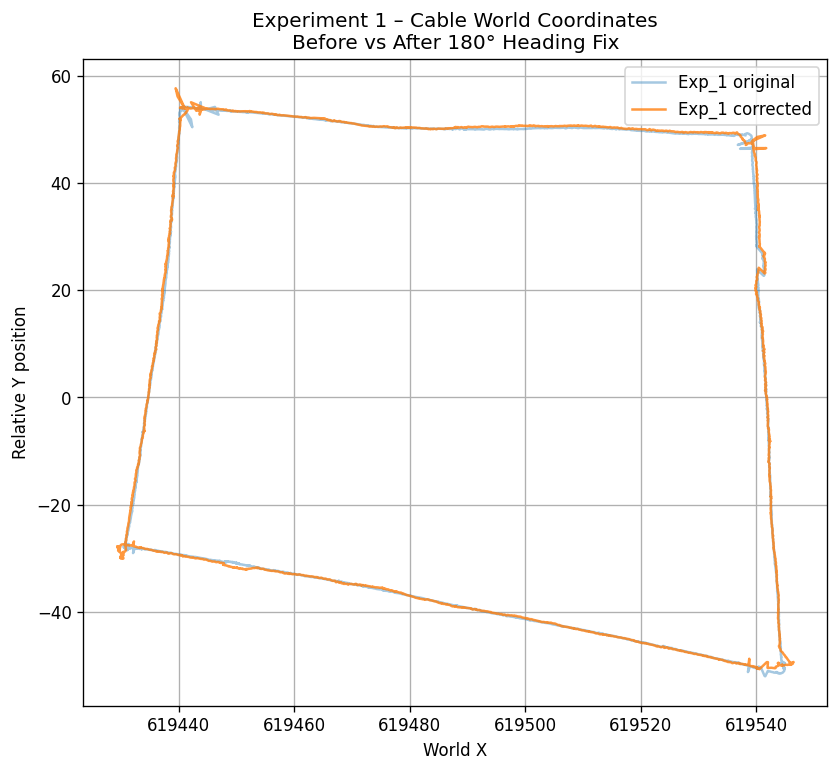

In [10]:
# =============================================================================
# 6. PLOTTING
#    (A) Experiments 2–5 after fix (they should all agree)
#    (B) Experiment 1: before vs after (to show the heading fix effect)
# =============================================================================

# ---------- (A) Exp 2–5 together, Y-centered, after fix ---------- We want to check the SHAPE of the curve only
plt.figure(figsize=(8, 7))
for exp in ["Exp_2", "Exp_3", "Exp_4", "Exp_5"]:
    xy = norm_xy_fixed[exp].copy()
    xy[:, 1] -= xy[:, 1].mean()   # center Y to see small differences better
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        label=exp,
        alpha=0.35,
        linewidth=1.5,
    )

plt.title("CCOG Cable World Coordinates (Fixed, Direction Normalized, Y-Centered)\nExperiments 2–5")
plt.xlabel("World X")
plt.ylabel("Relative Y position")
plt.grid(True)
plt.legend()
plt.show()

# ---------- (B) Experiment 1: BEFORE vs AFTER heading fix ----------
plt.figure(figsize=(8, 7))

# before fix (original)
xy_before = norm_xy_original["Exp_1"].copy()
xy_before[:, 1] -= xy_before[:, 1].mean()
plt.plot(
    xy_before[:, 0],
    xy_before[:, 1],
    label="Exp_1 original",
    alpha=0.4,
    linewidth=1.5,
)

# after fix
xy_after = norm_xy_fixed["Exp_1"].copy()
xy_after[:, 1] -= xy_after[:, 1].mean()
plt.plot(
    xy_after[:, 0],
    xy_after[:, 1],
    label="Exp_1 corrected",
    alpha=0.8,
    linewidth=1.5,
)

plt.title("Experiment 1 – Cable World Coordinates\nBefore vs After 180° Heading Fix")
plt.xlabel("World X")
plt.ylabel("Relative Y position")
plt.grid(True)
plt.legend()
plt.show()

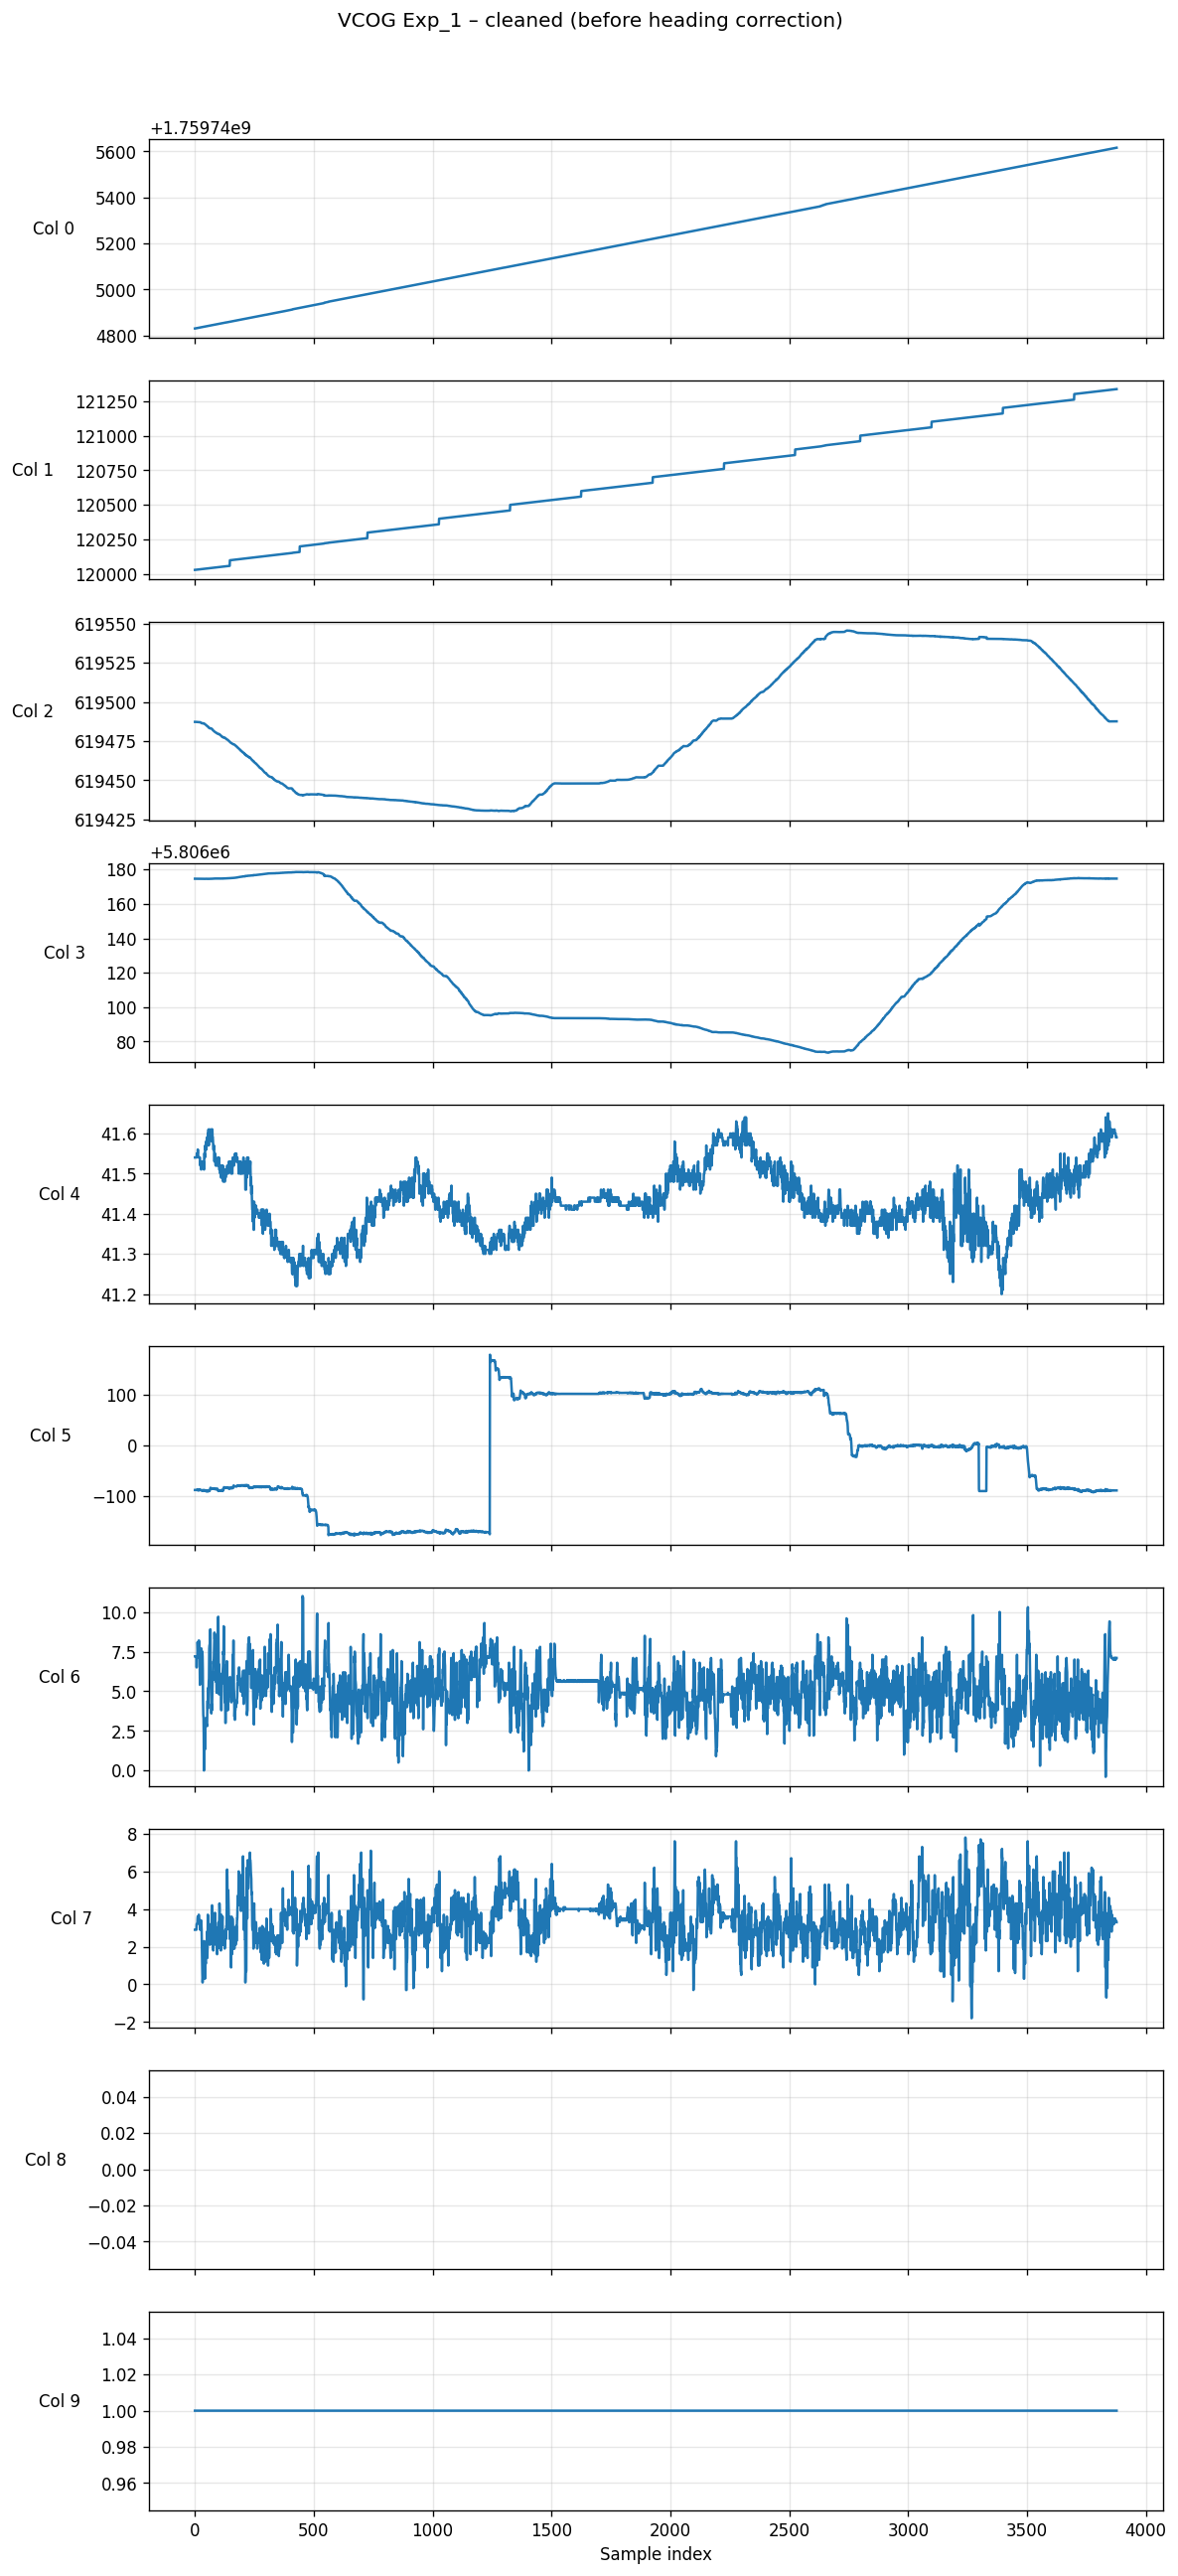

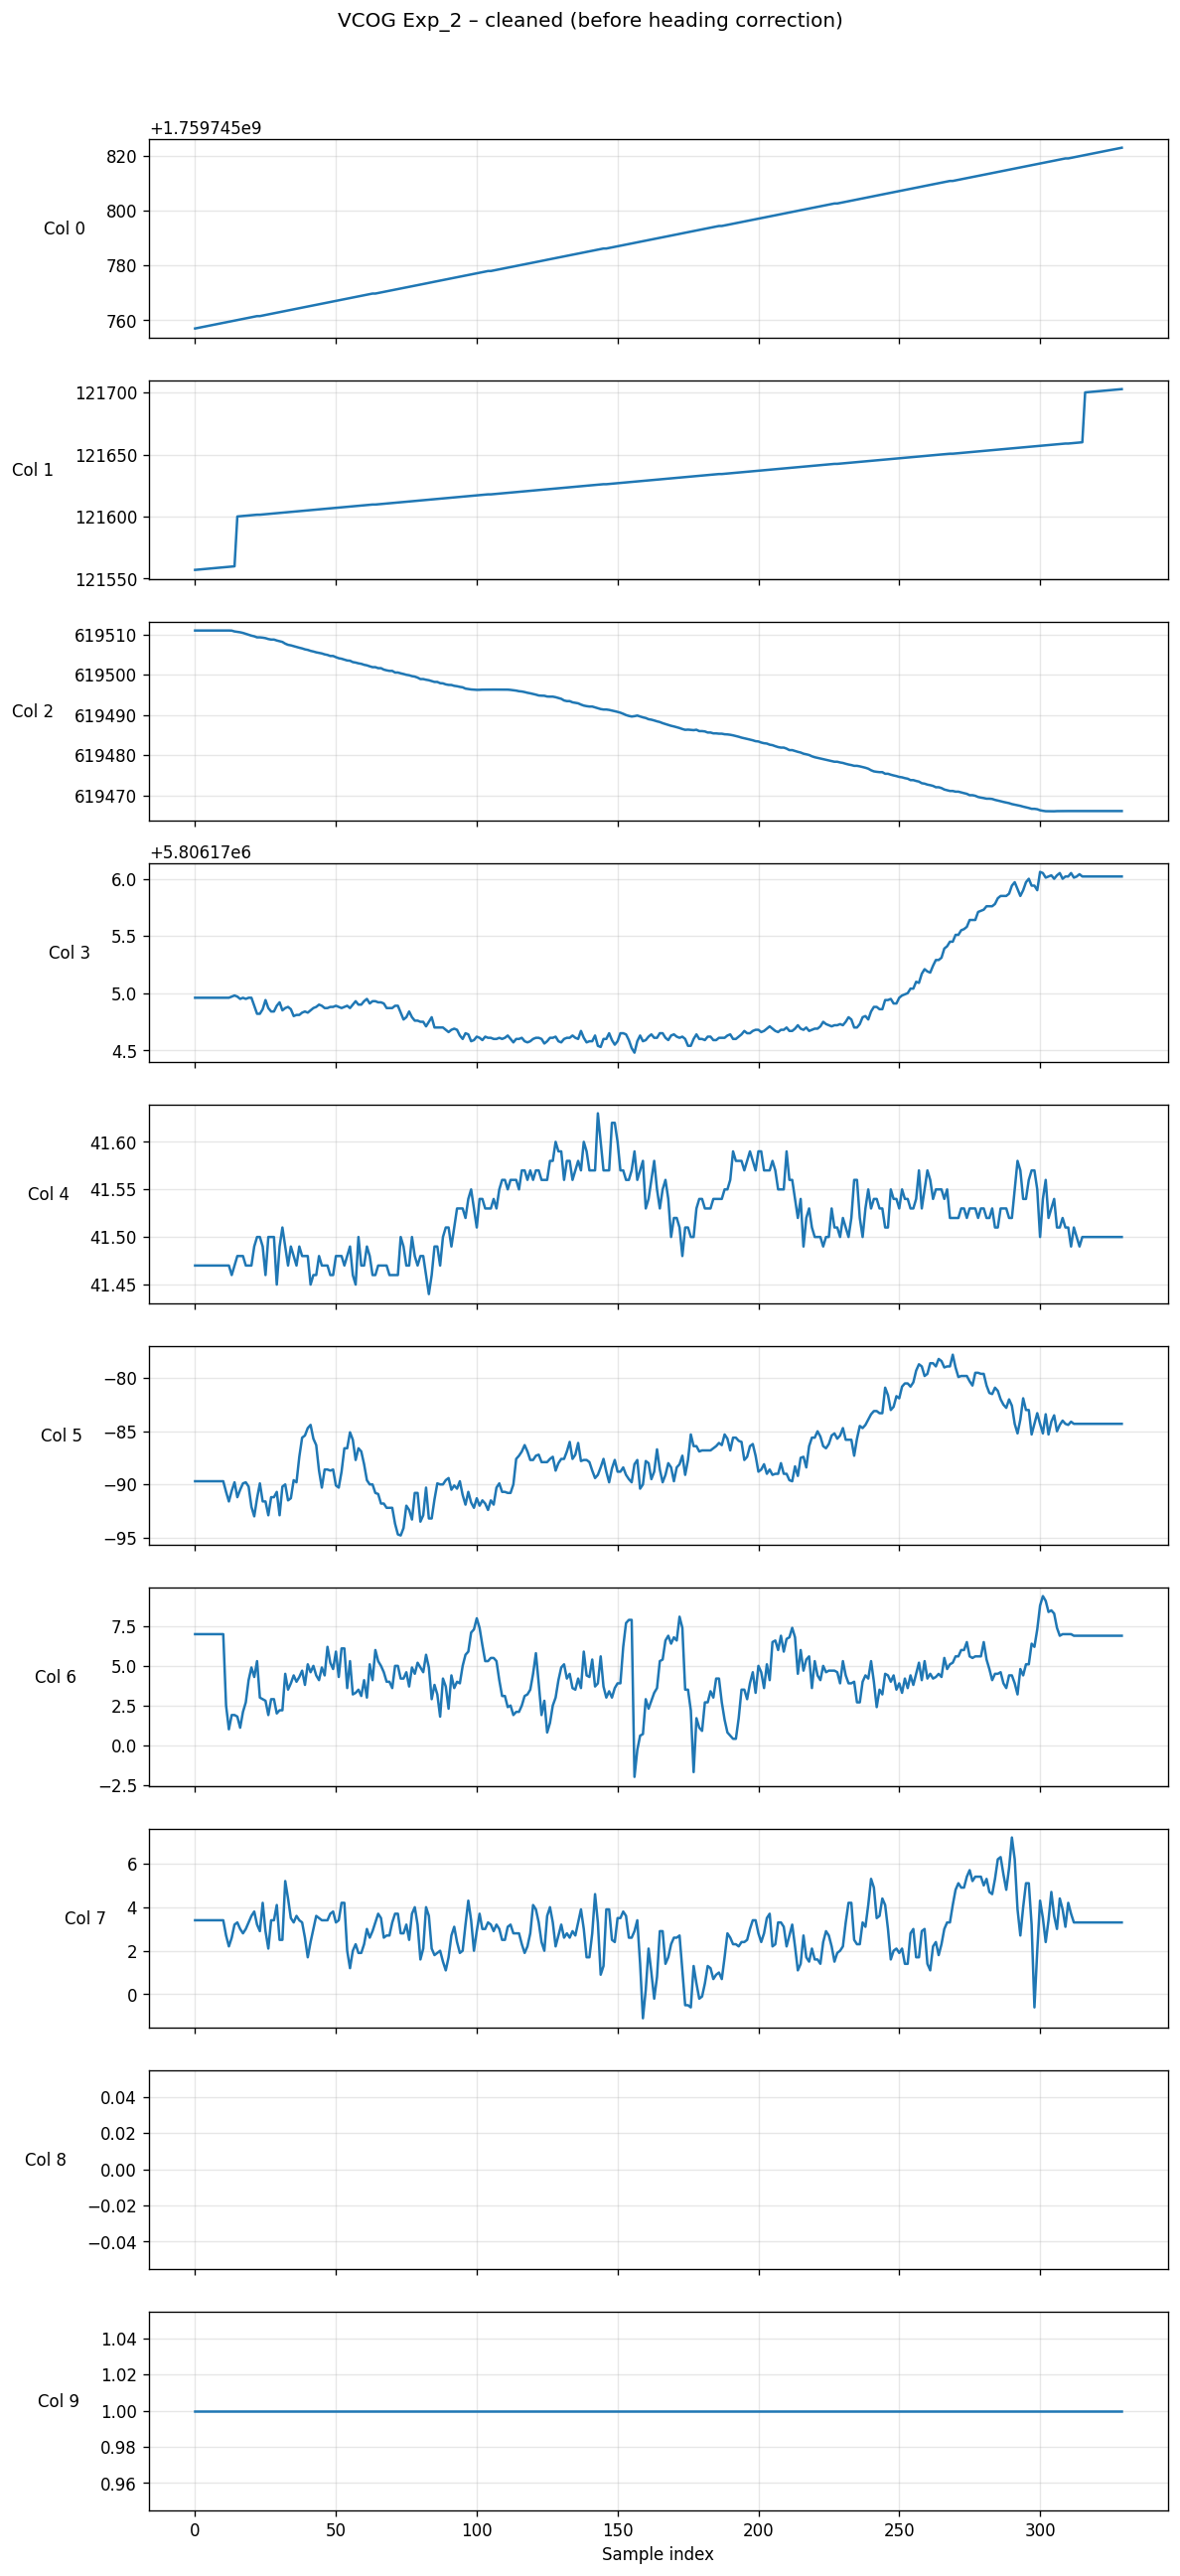

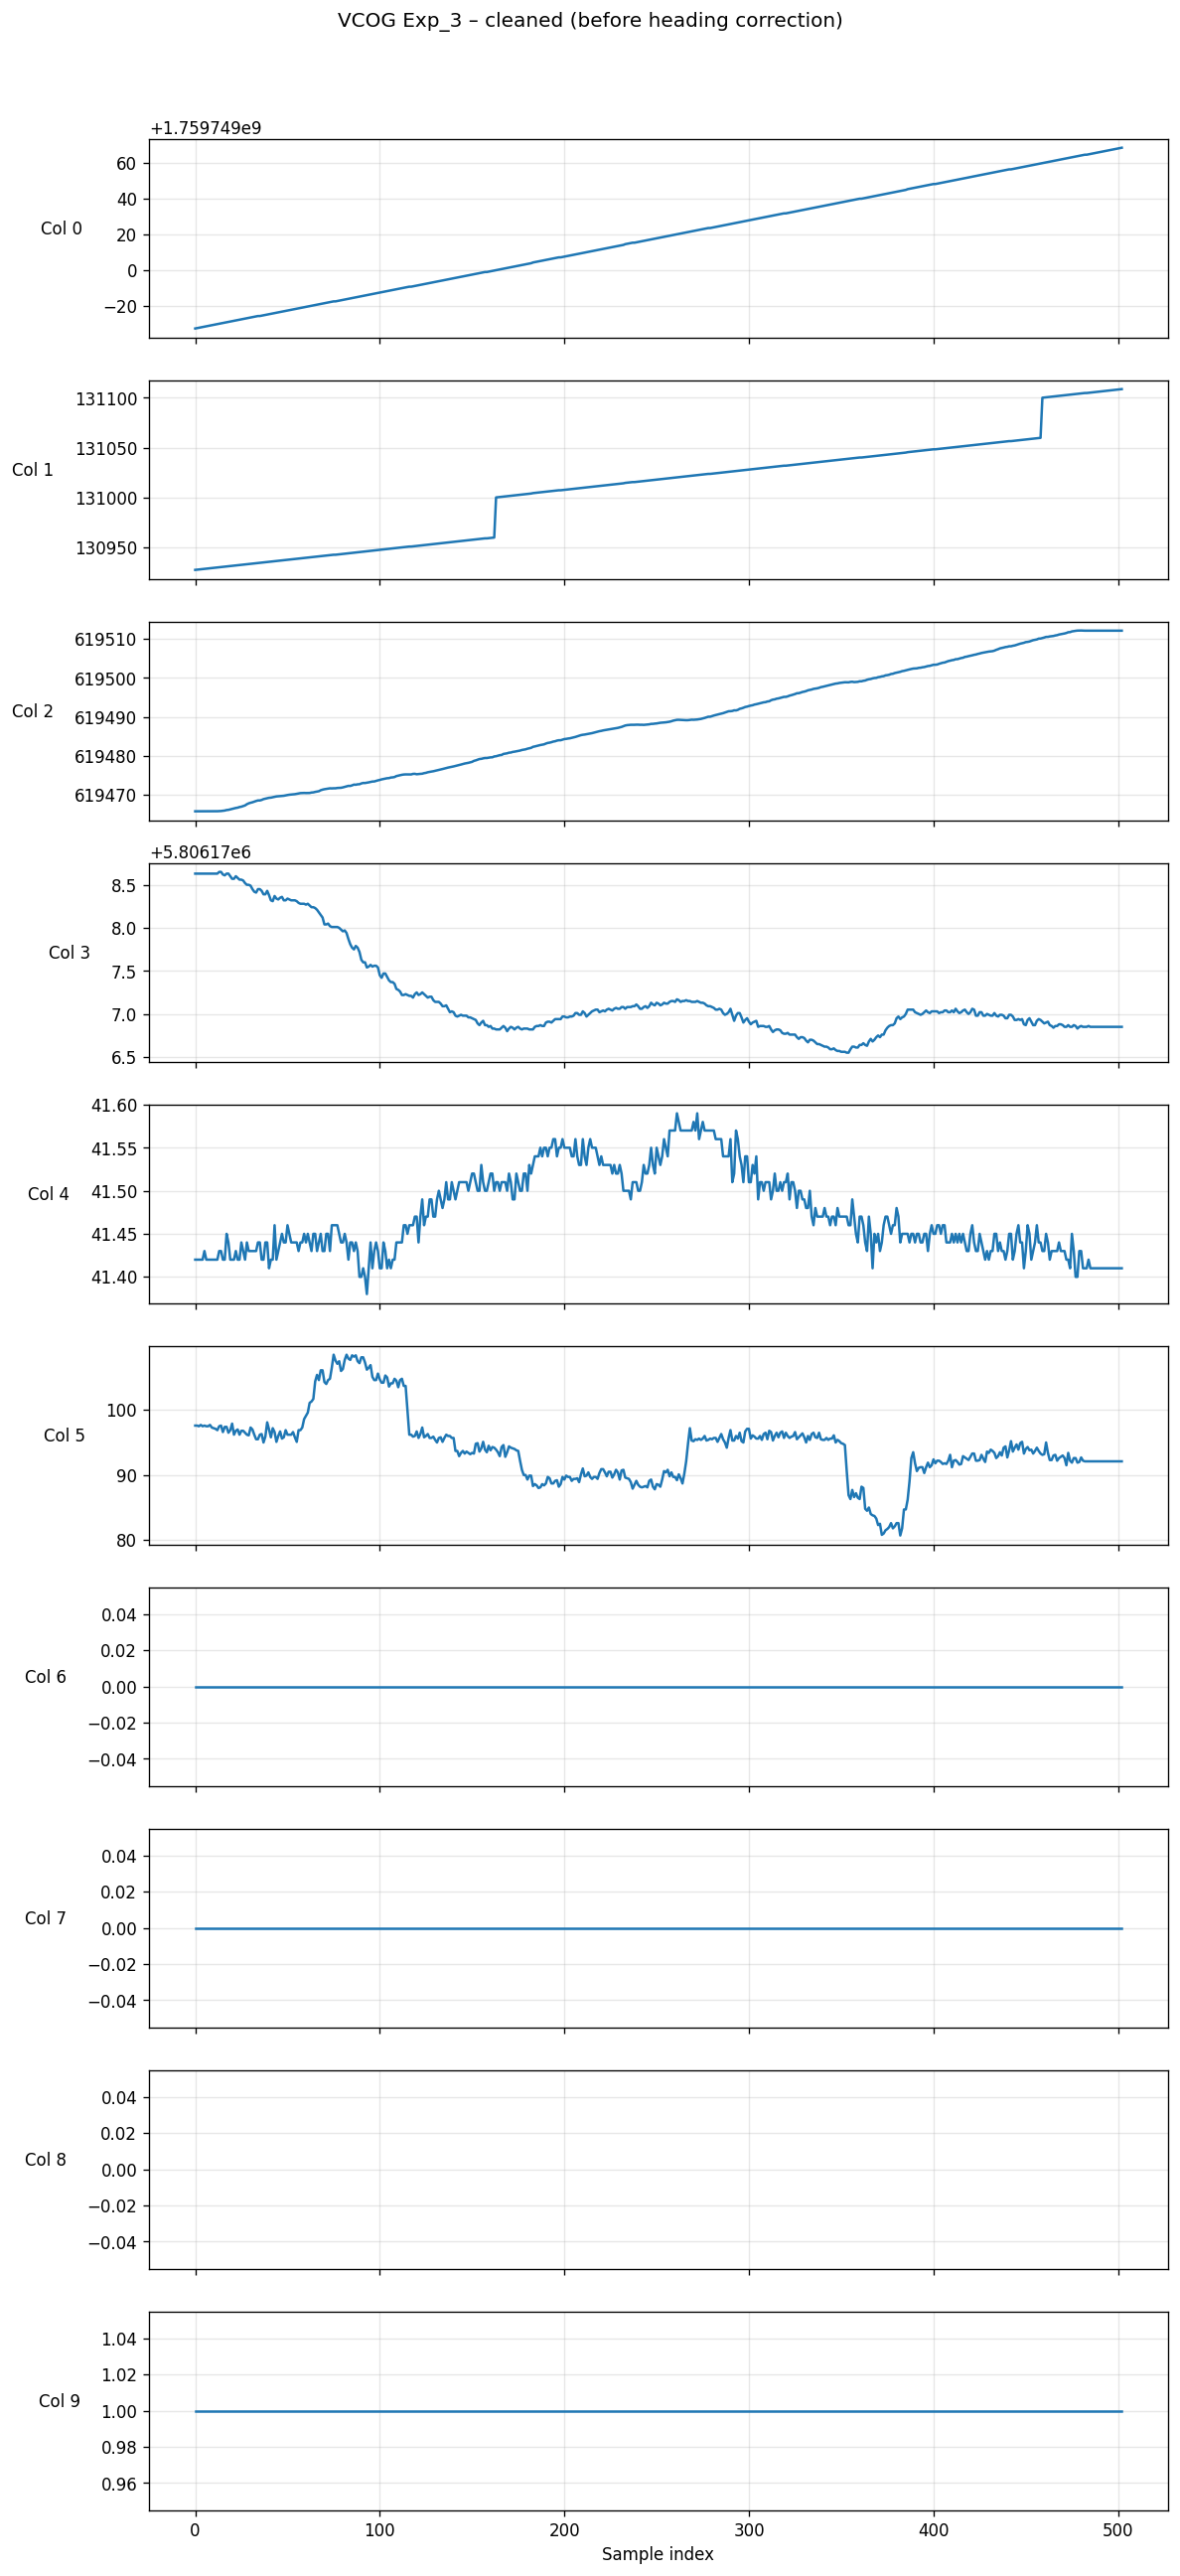

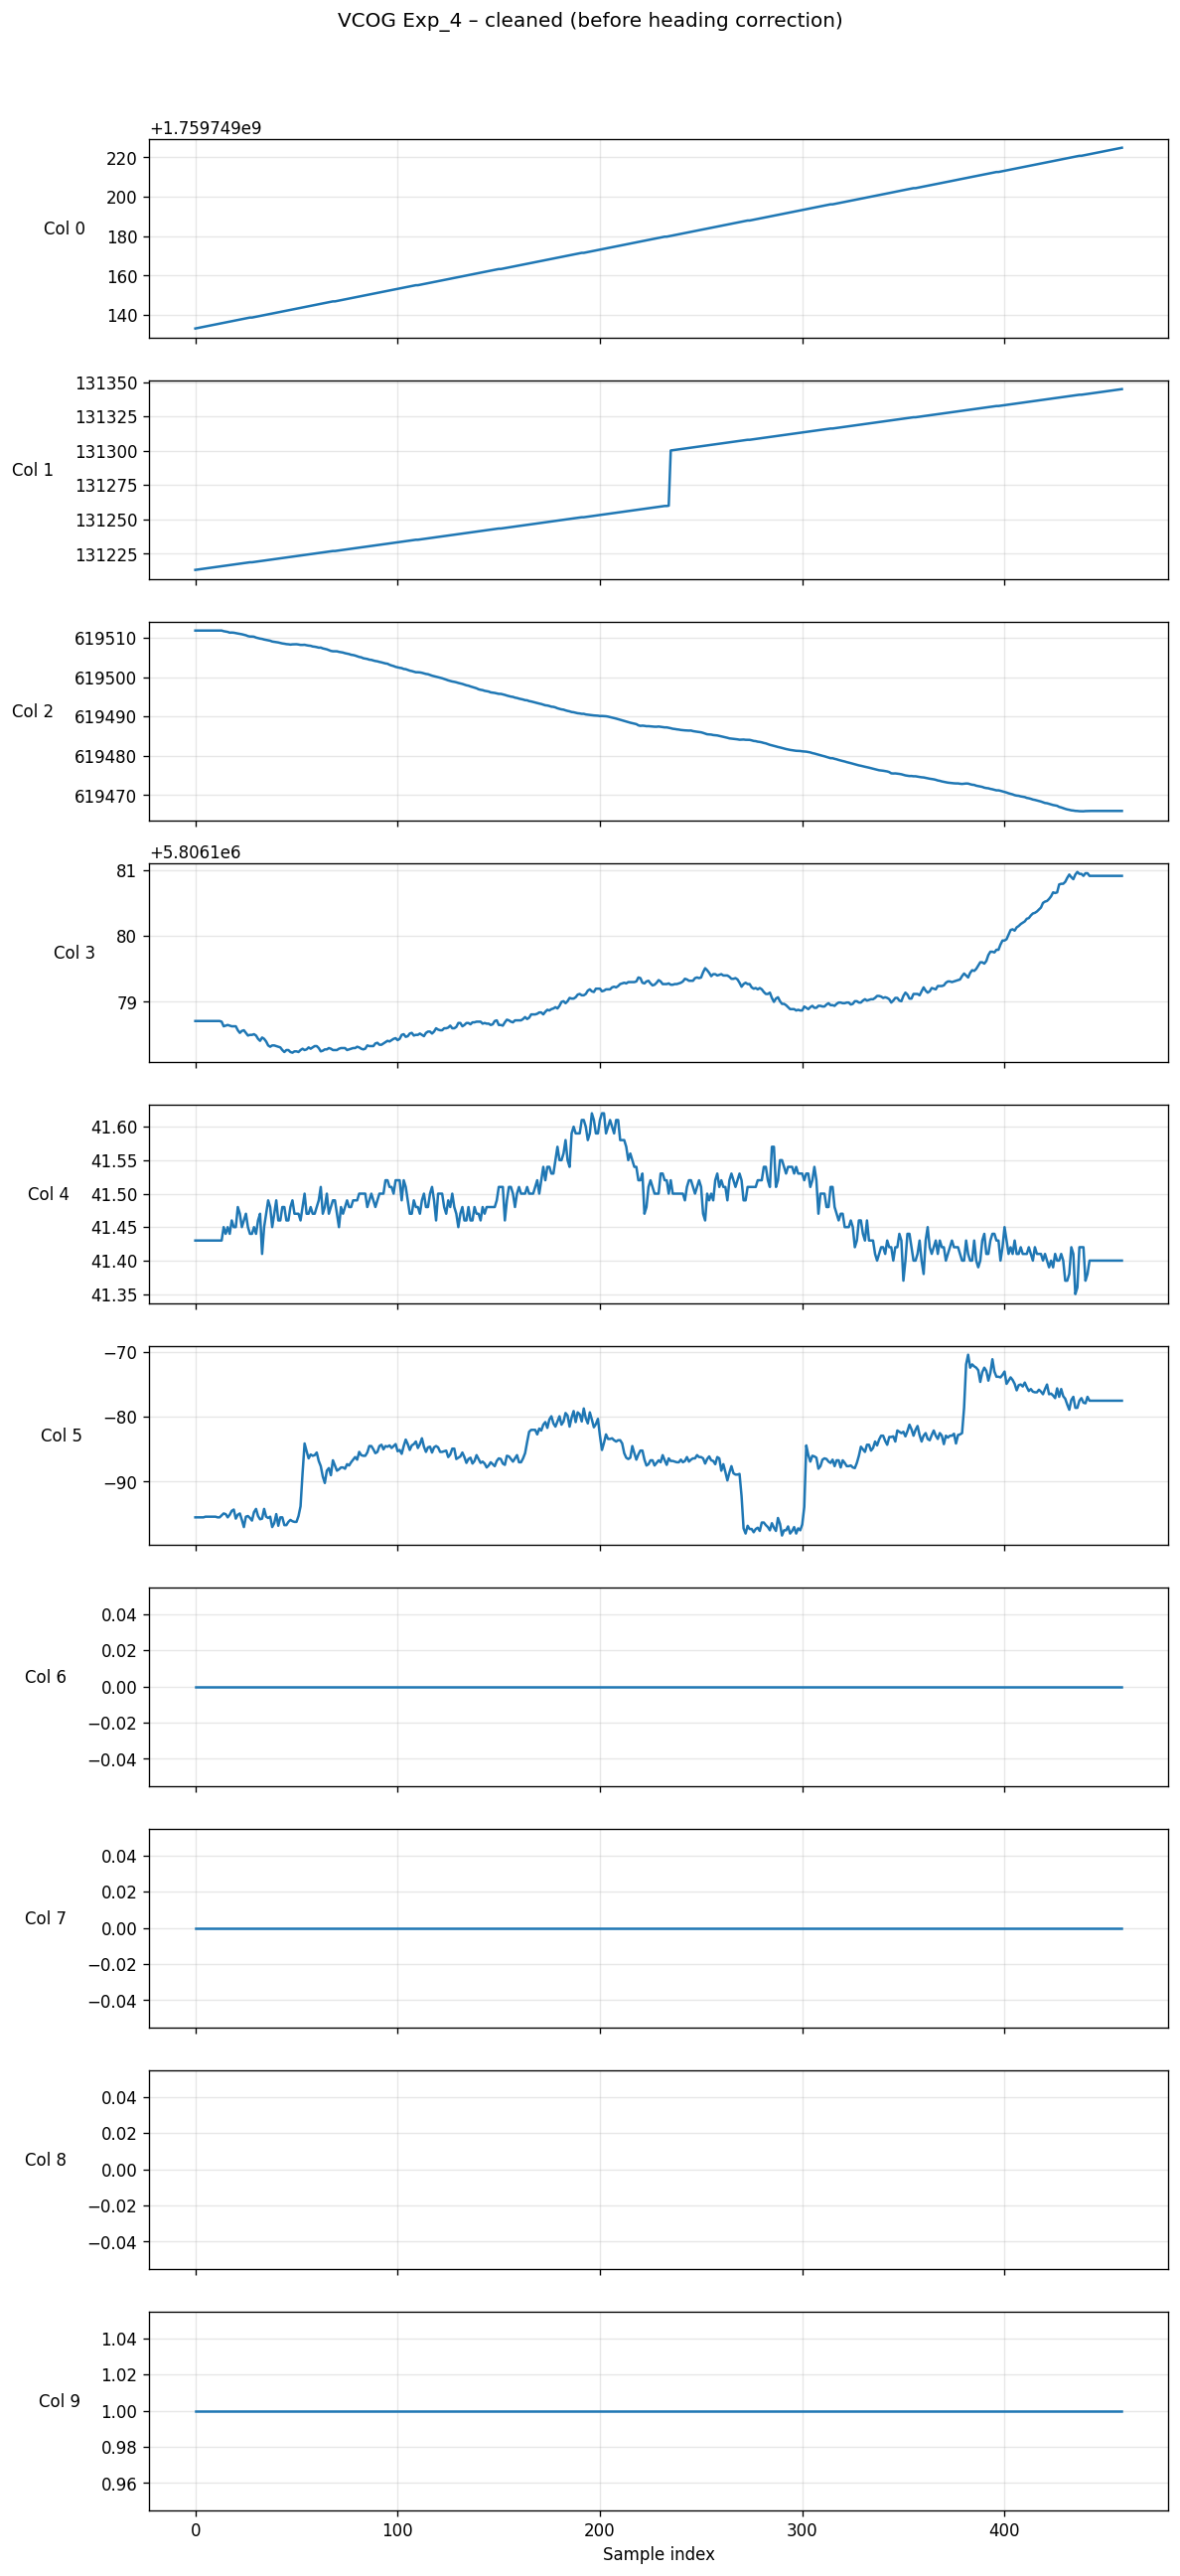

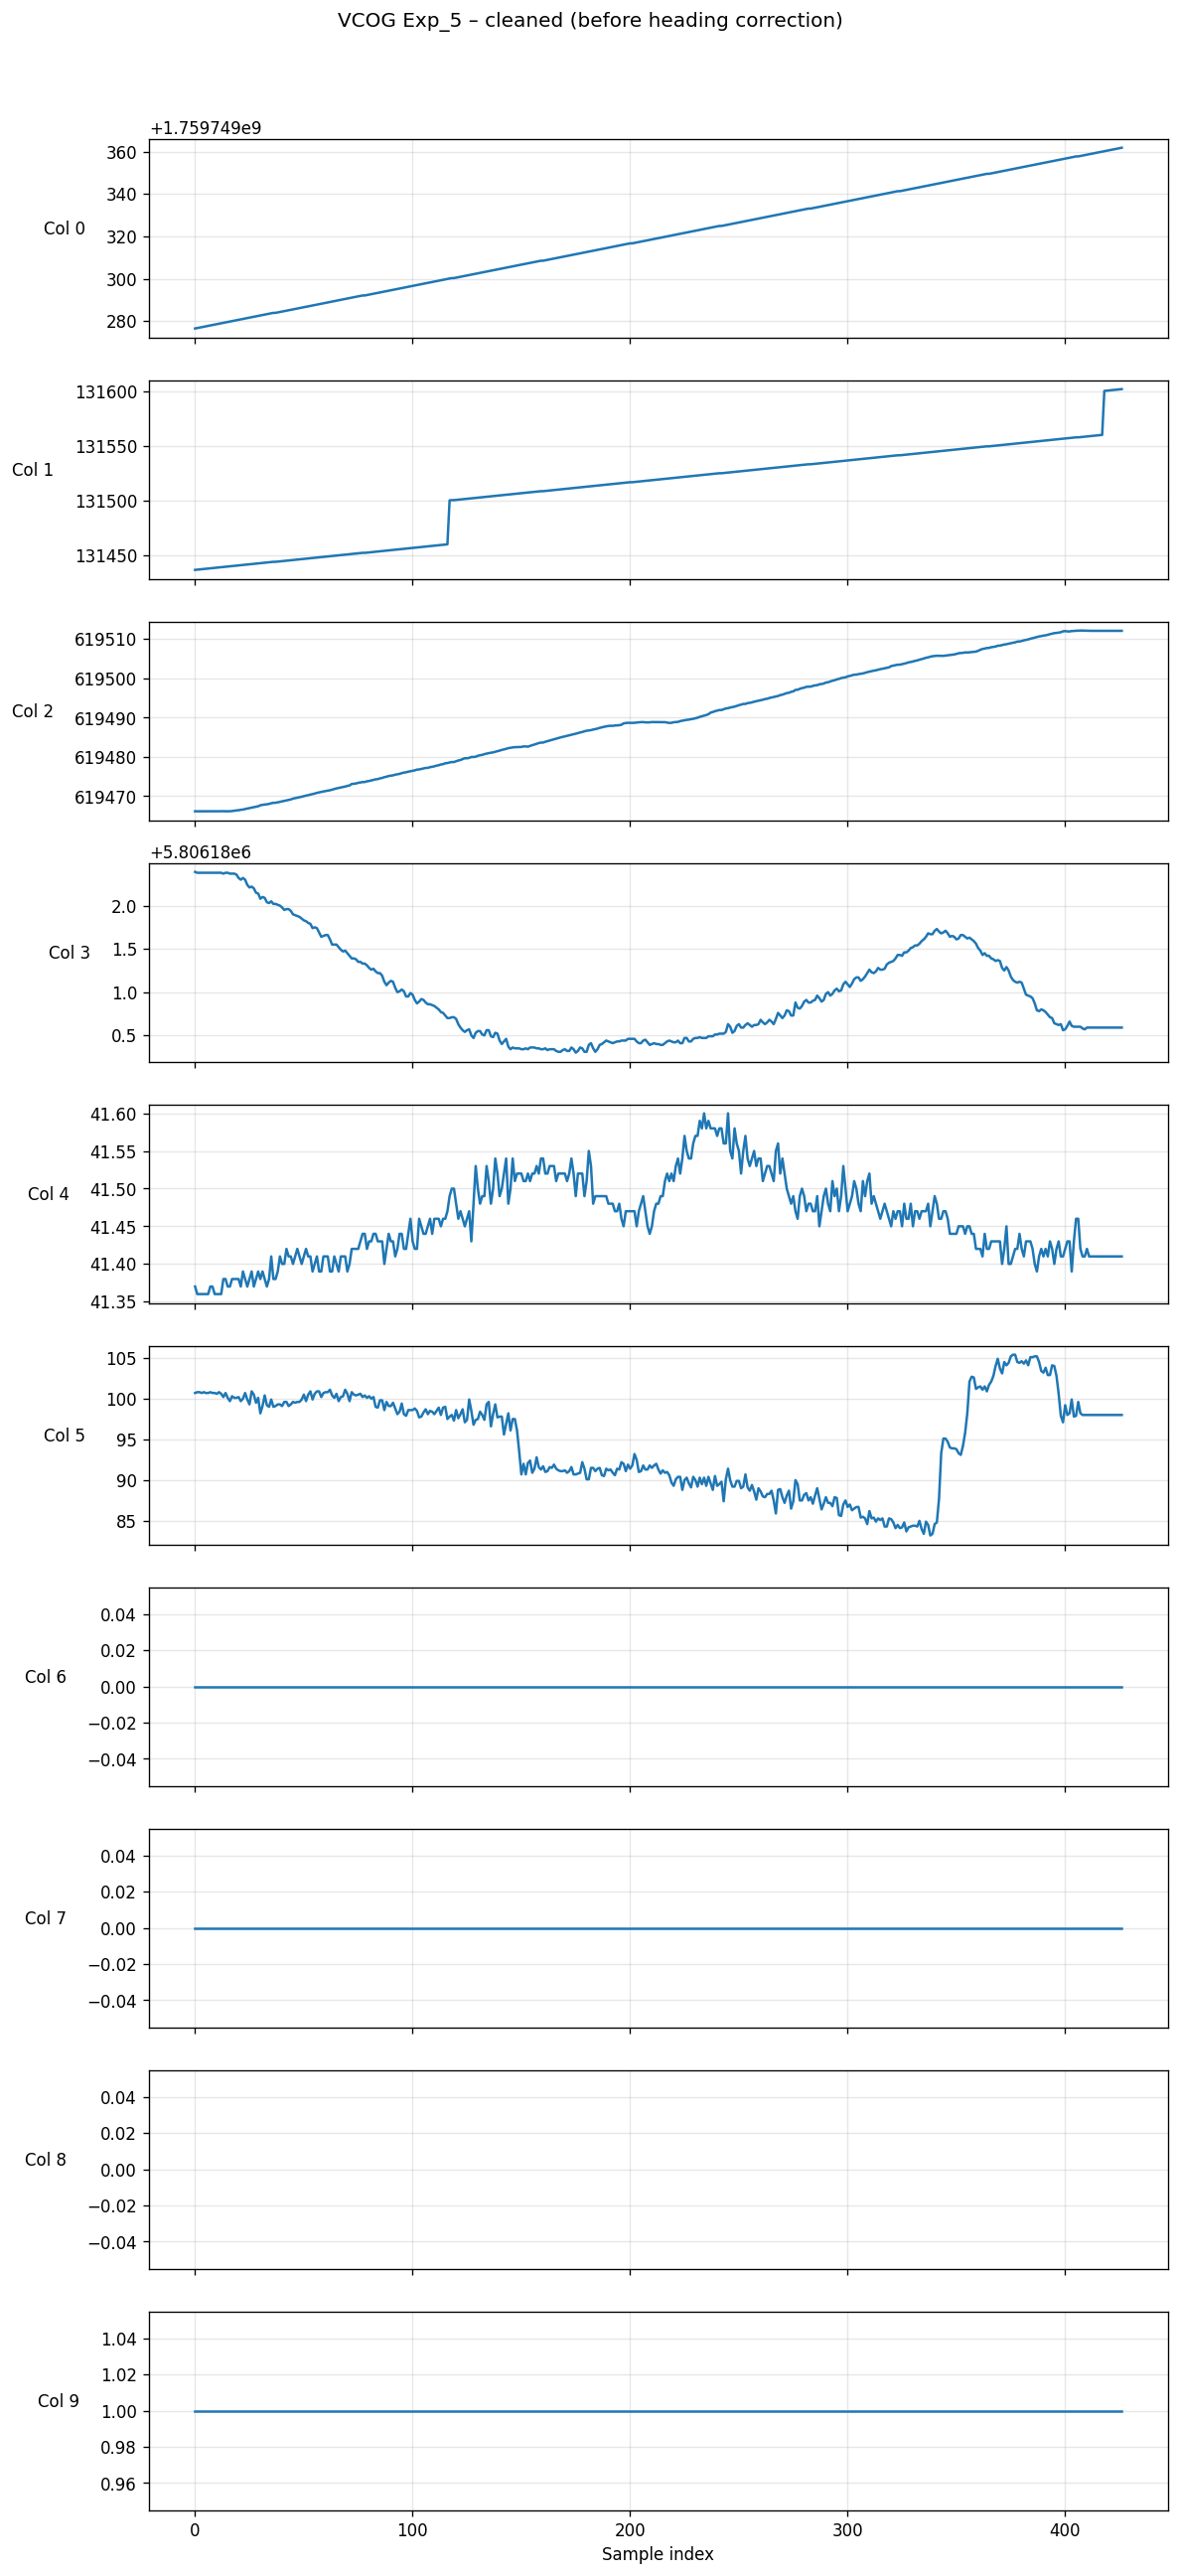

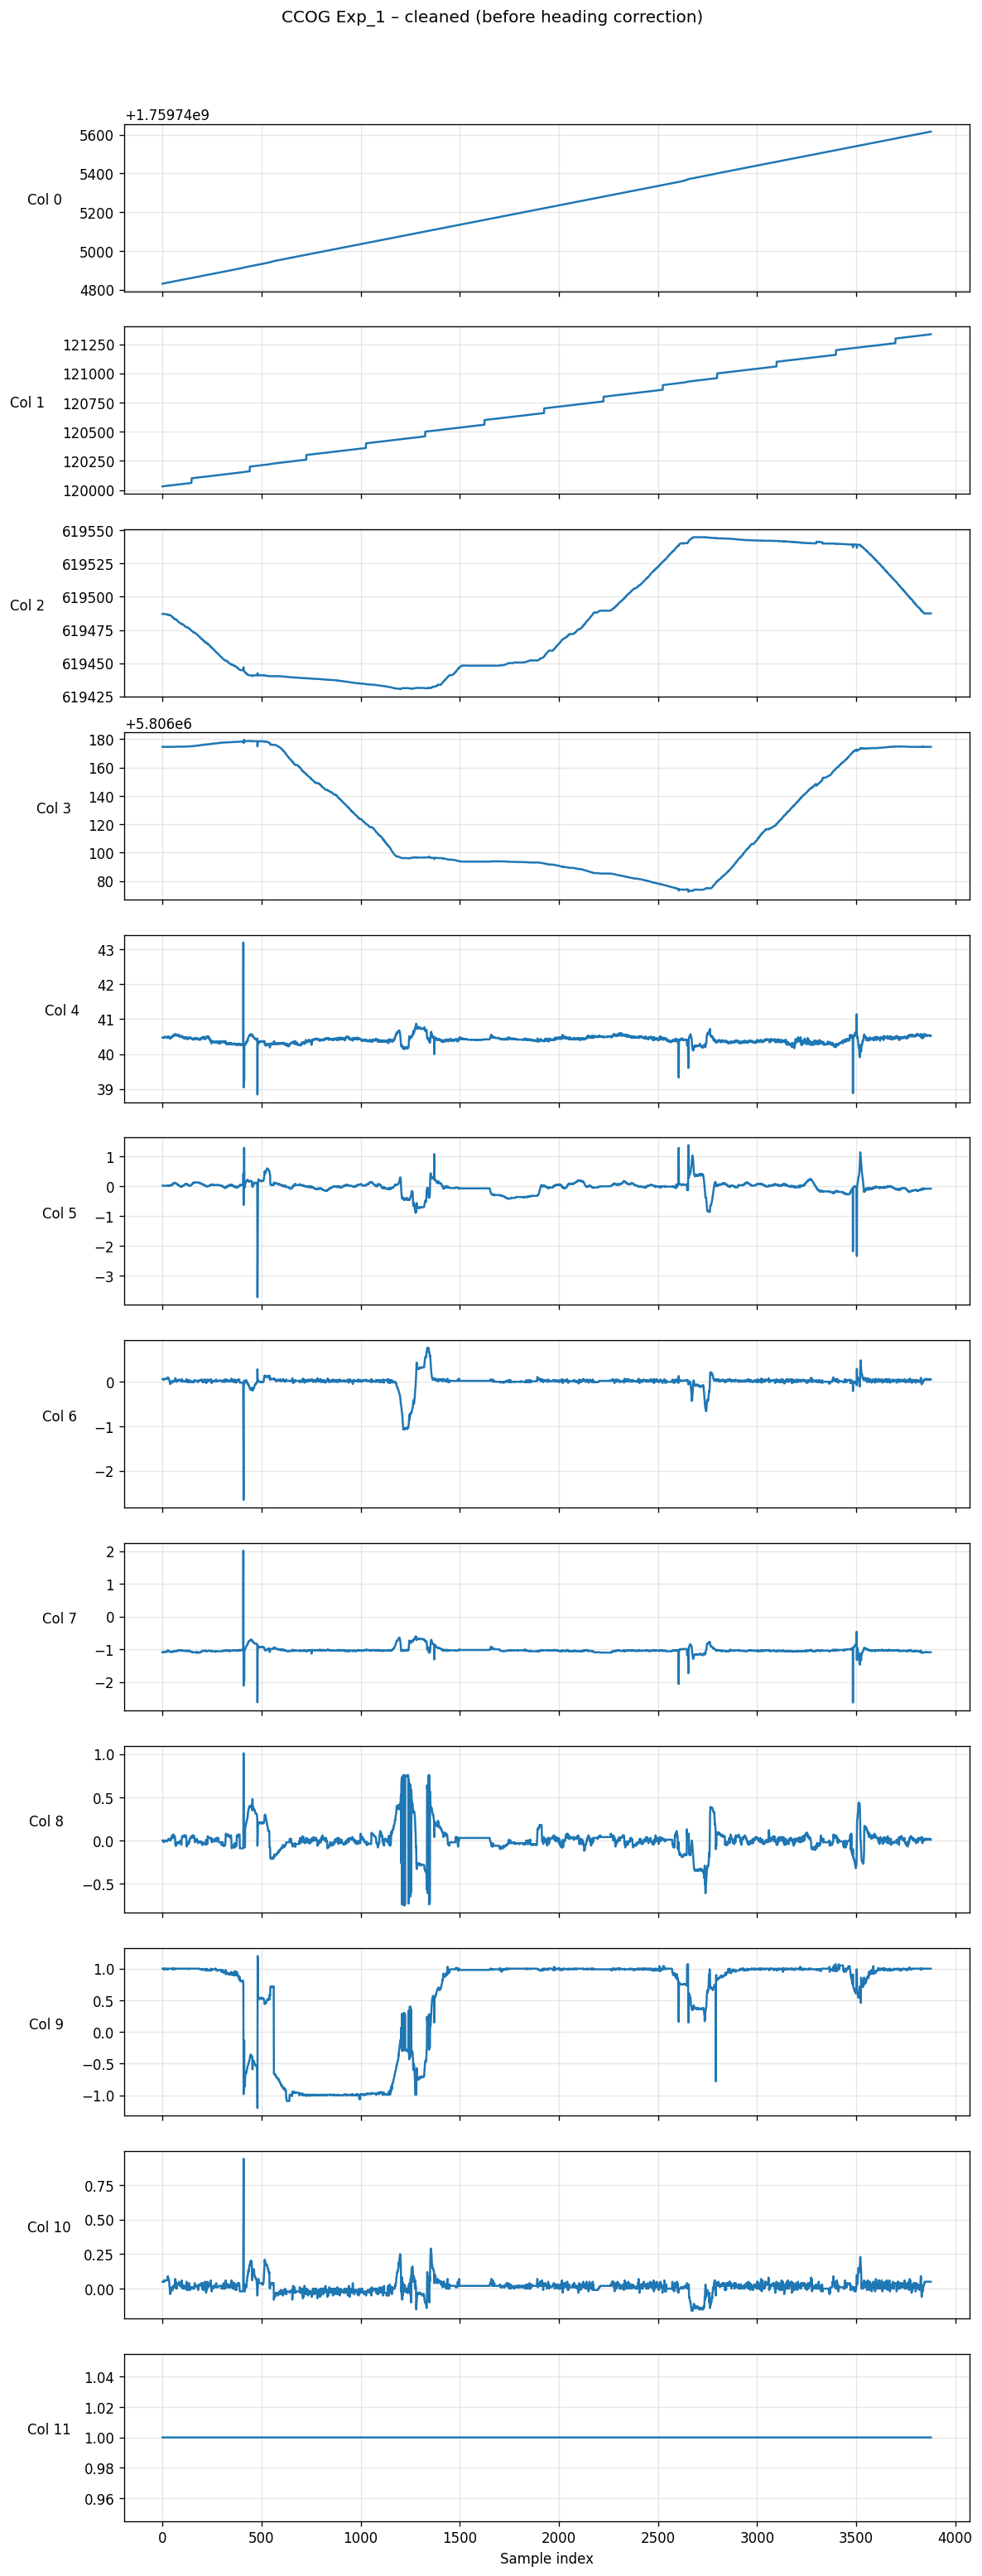

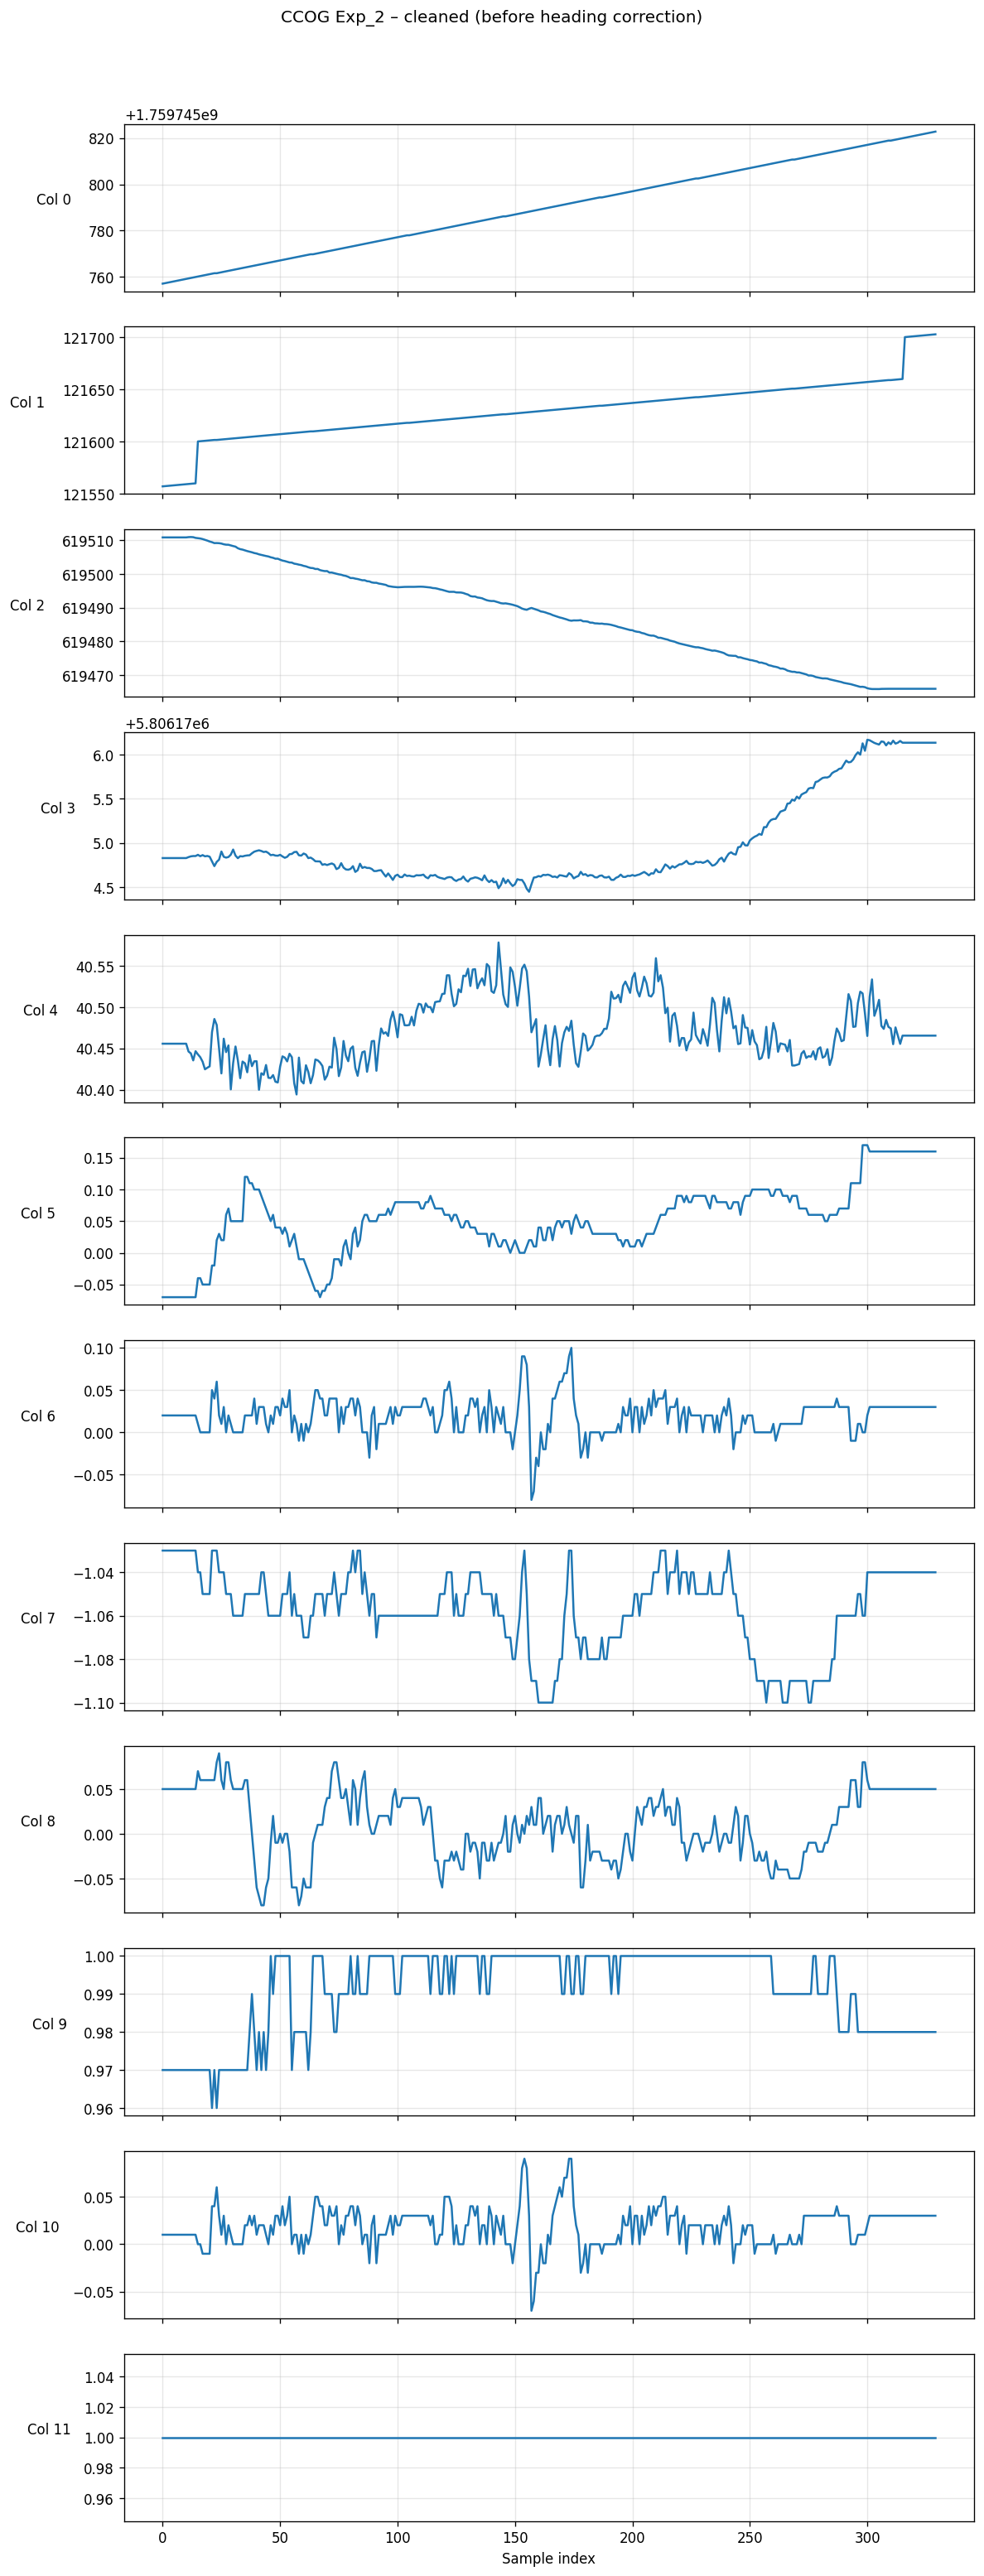

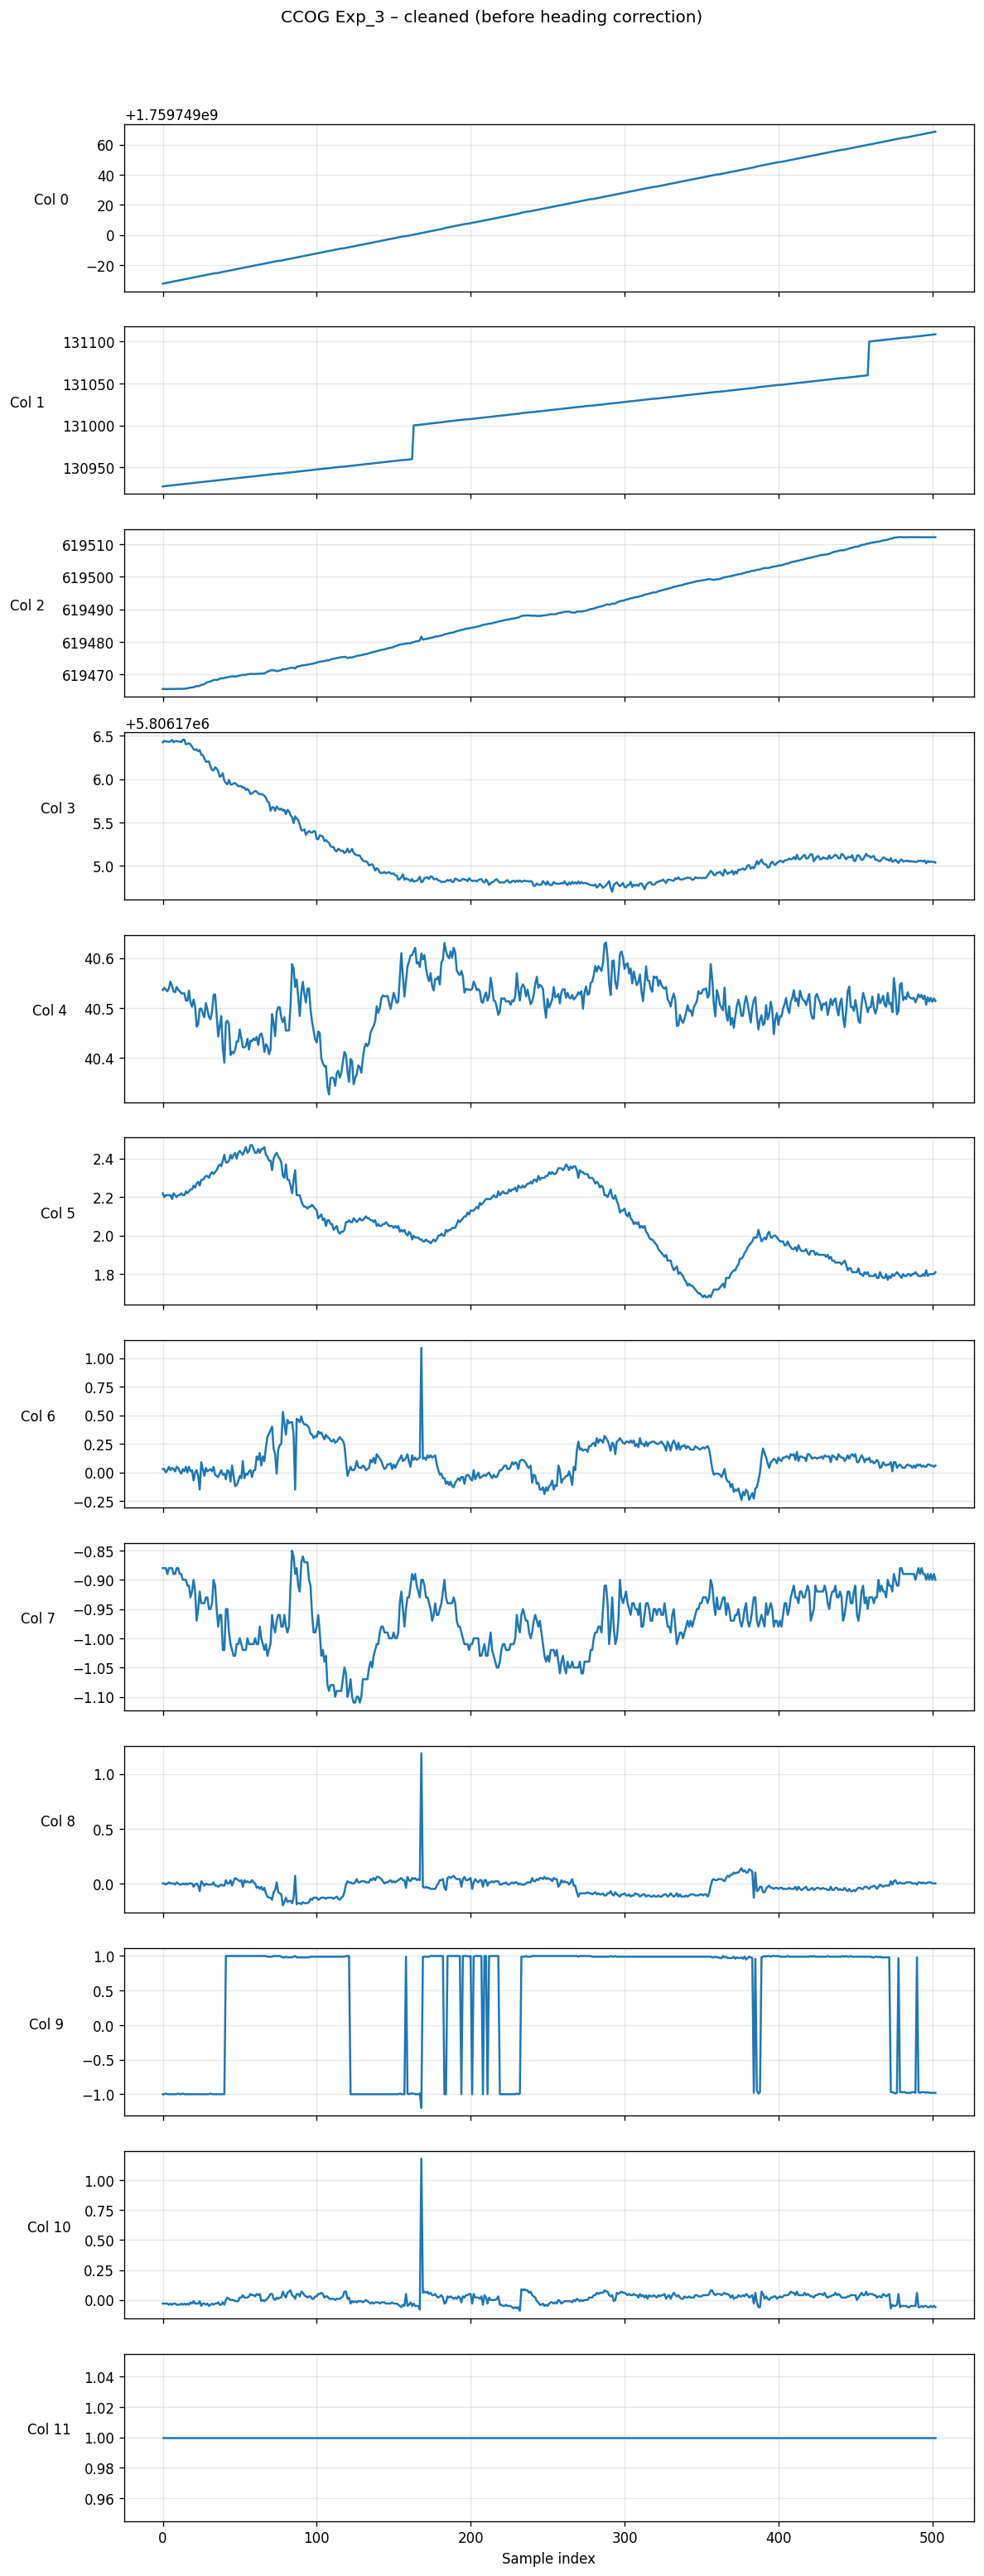

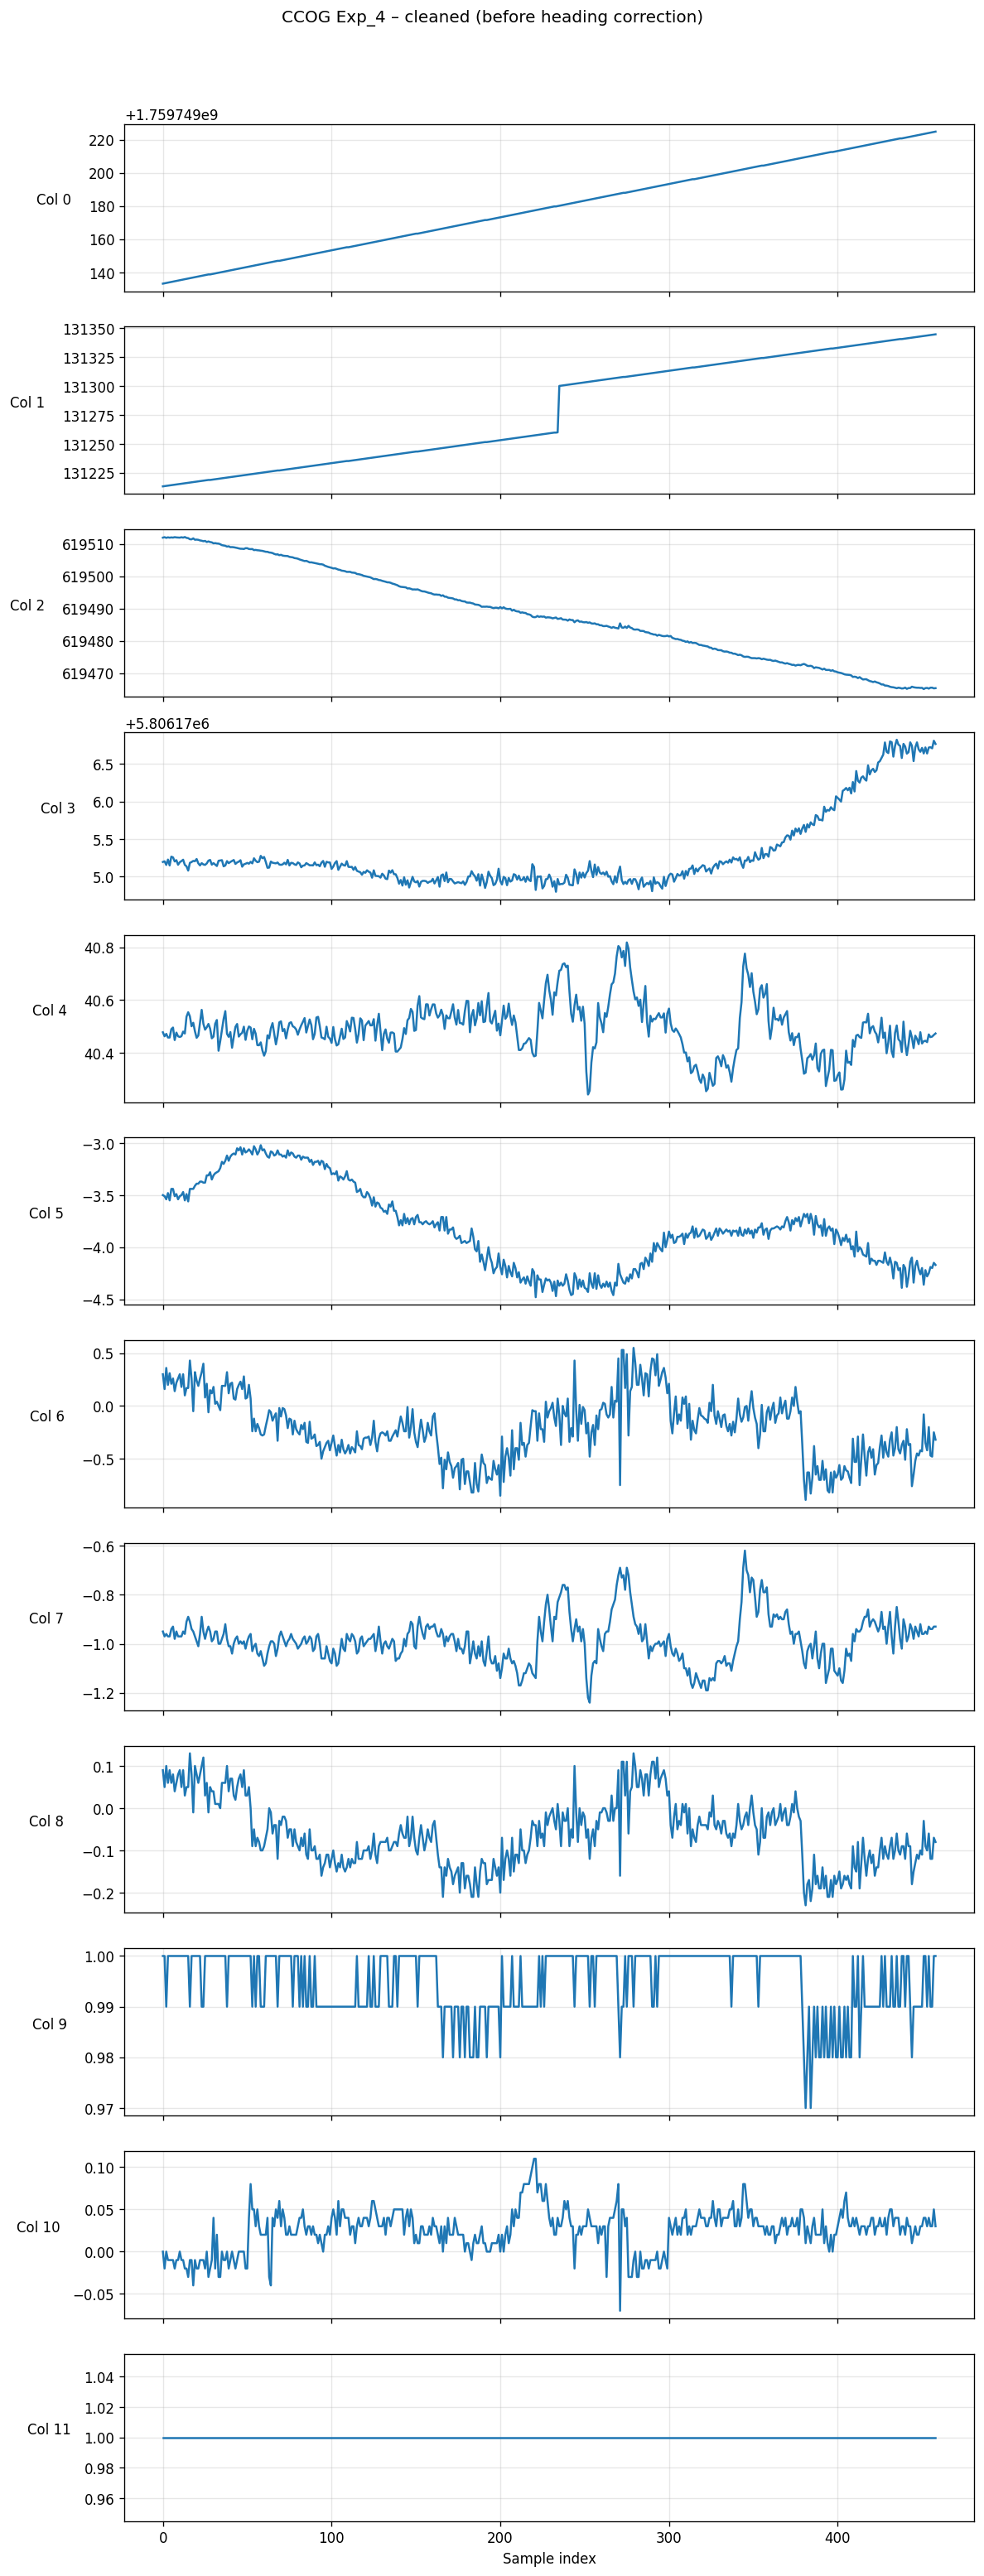

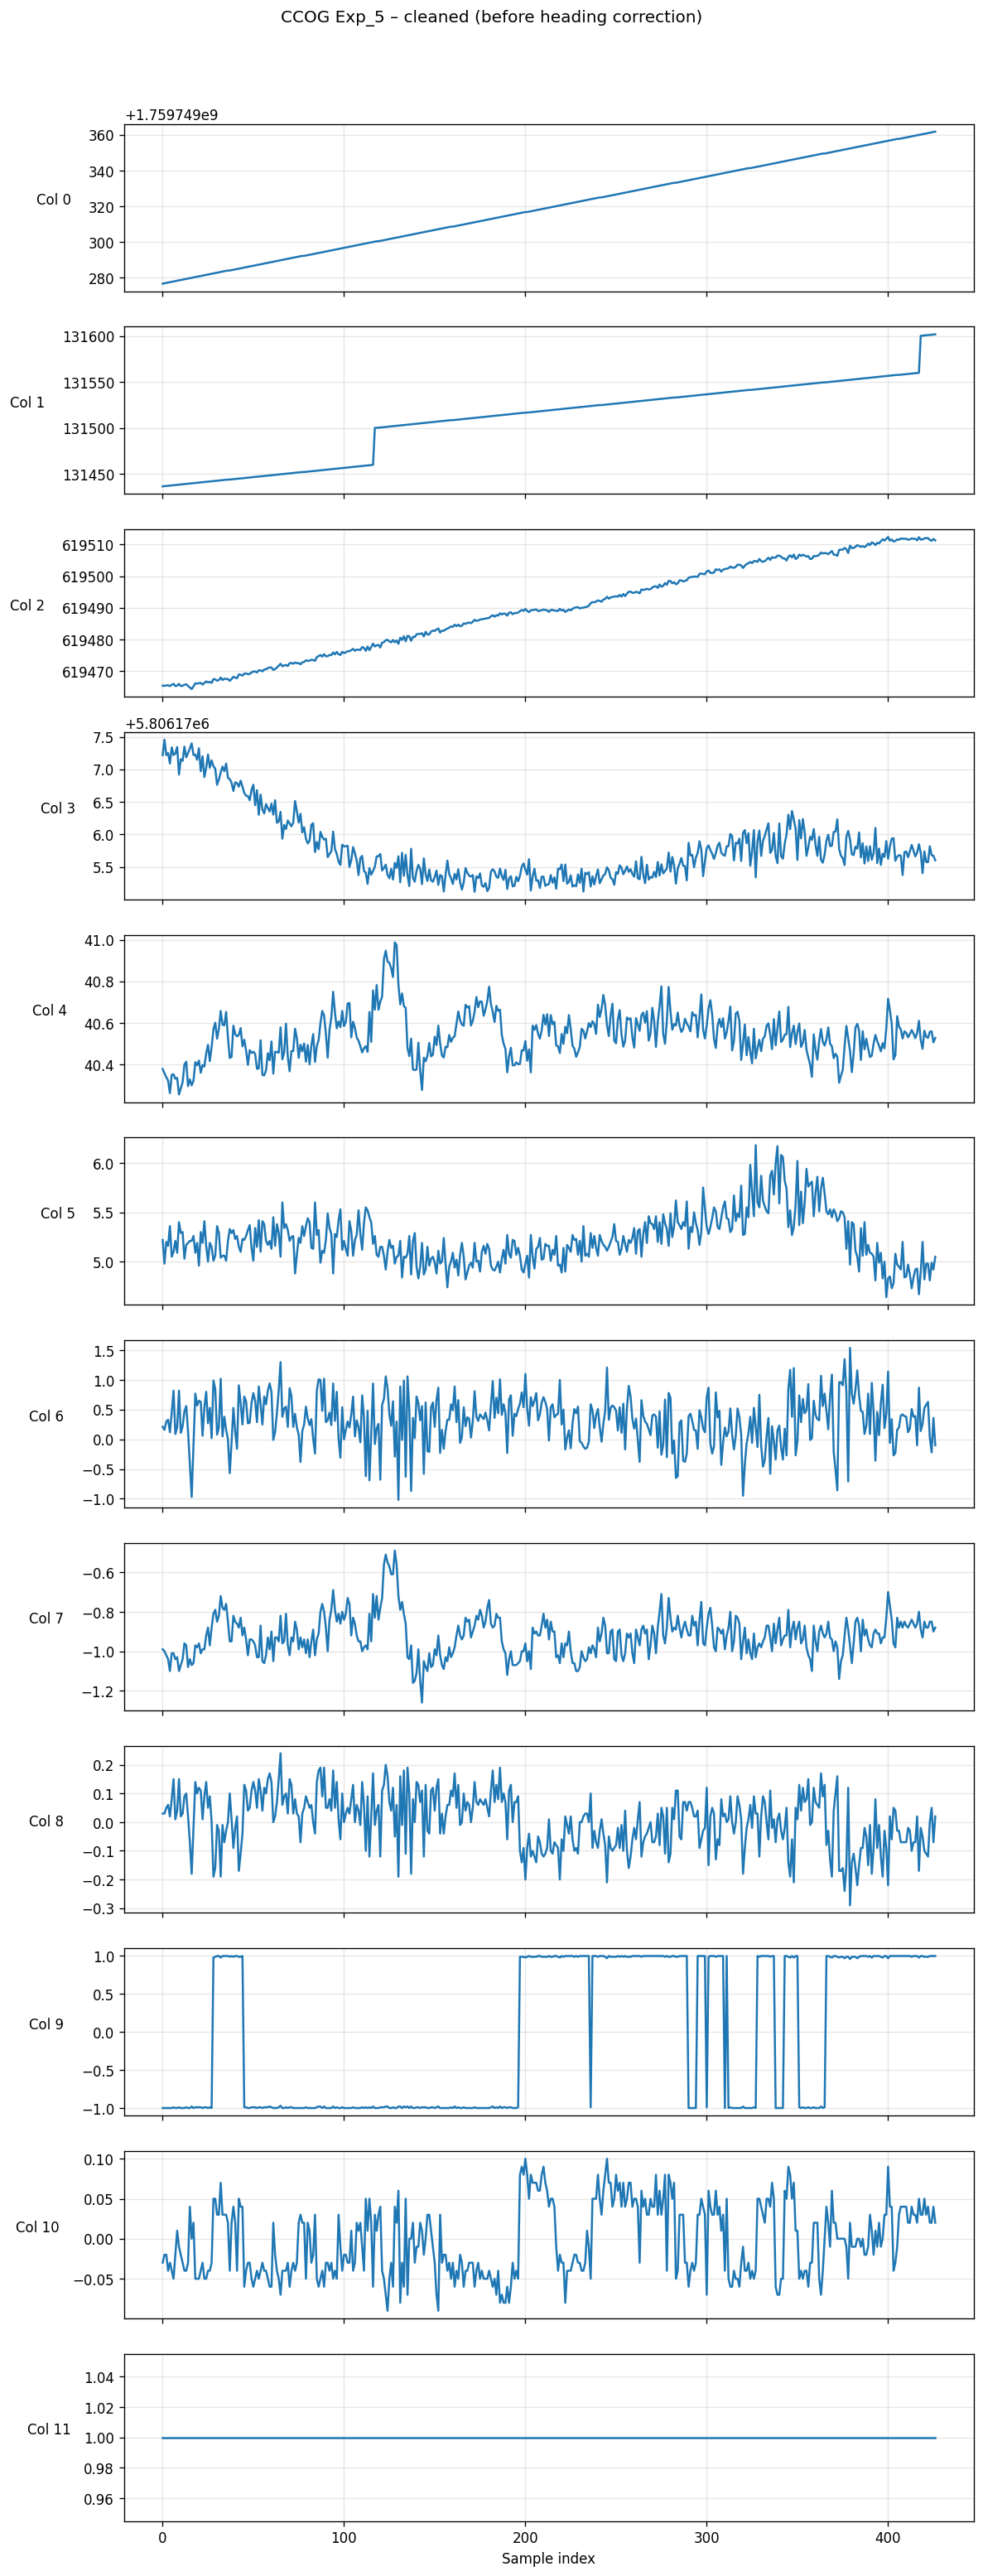

In [11]:
def plot_all_columns(data_dict, title_prefix):
    """
    data_dict: dict like {"Exp_1": df1, "Exp_2": df2, ...}
    title_prefix: "VCOG" or "CCOG" etc.
    """
    for exp, df in data_dict.items():
        n_cols = df.shape[1]
        fig, axes = plt.subplots(
            n_cols, 1,
            figsize=(10, 2.2 * n_cols),
            sharex=True
        )
        if n_cols == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.plot(df.index, df.iloc[:, i])
            ax.set_ylabel(f"Col {i}", rotation=0, labelpad=25)
            ax.grid(True, alpha=0.3)

        axes[-1].set_xlabel("Sample index")
        fig.suptitle(
            f"{title_prefix} {exp} – cleaned (before heading correction)",
            fontsize=12
        )
        fig.tight_layout(rect=[0, 0, 1, 0.96])

        plt.show()


# ── Call these AFTER you’ve created vcog_clean and ccog_clean ──────────────
plot_all_columns(vcog_clean, "VCOG")
plot_all_columns(ccog_clean, "CCOG")

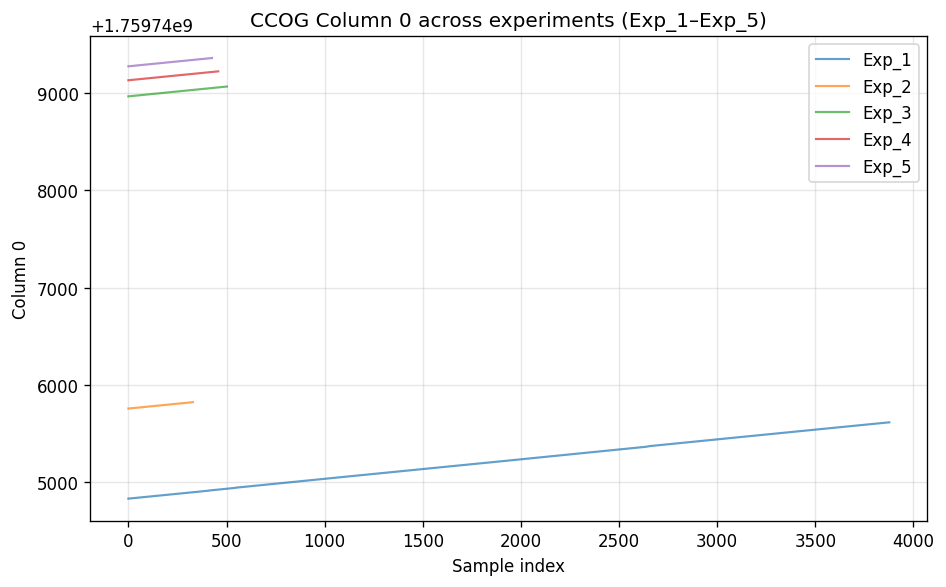

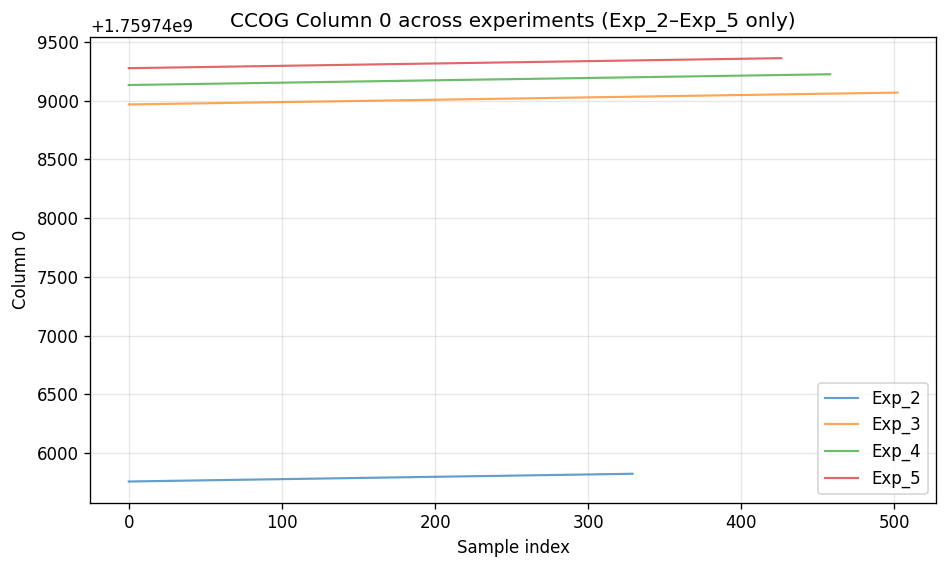

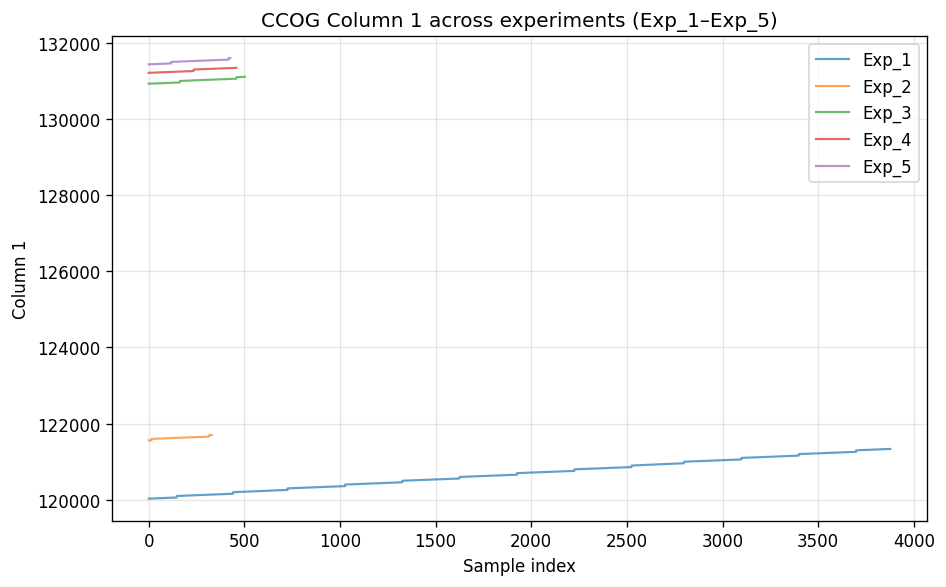

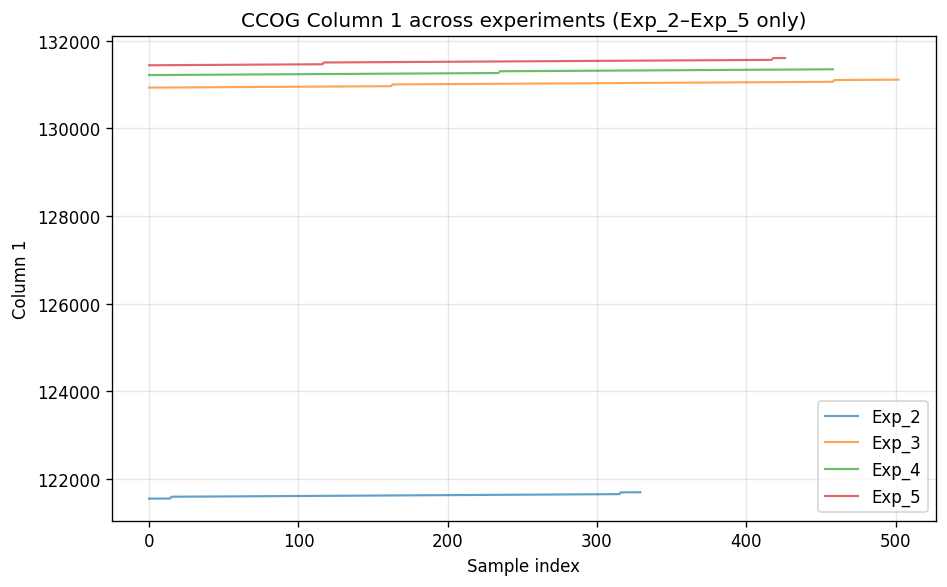

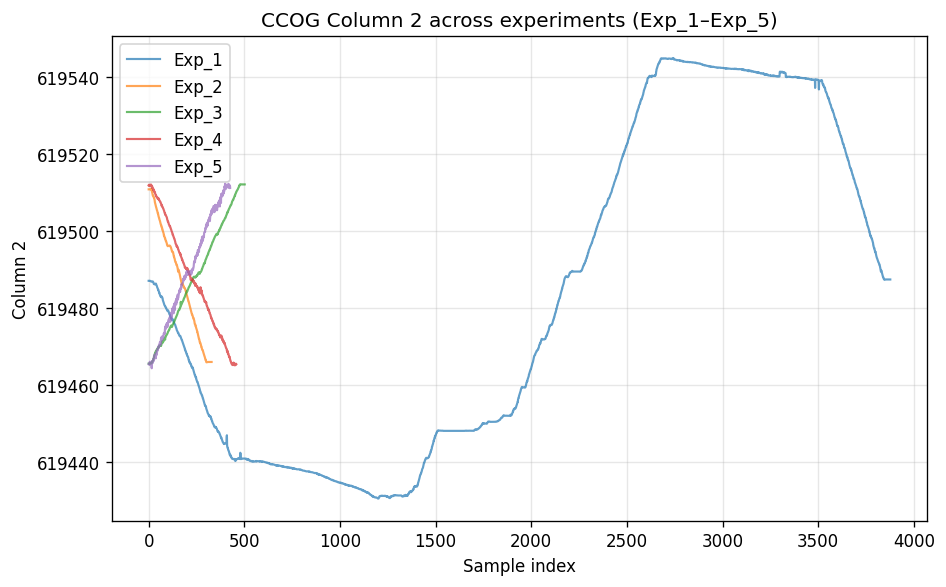

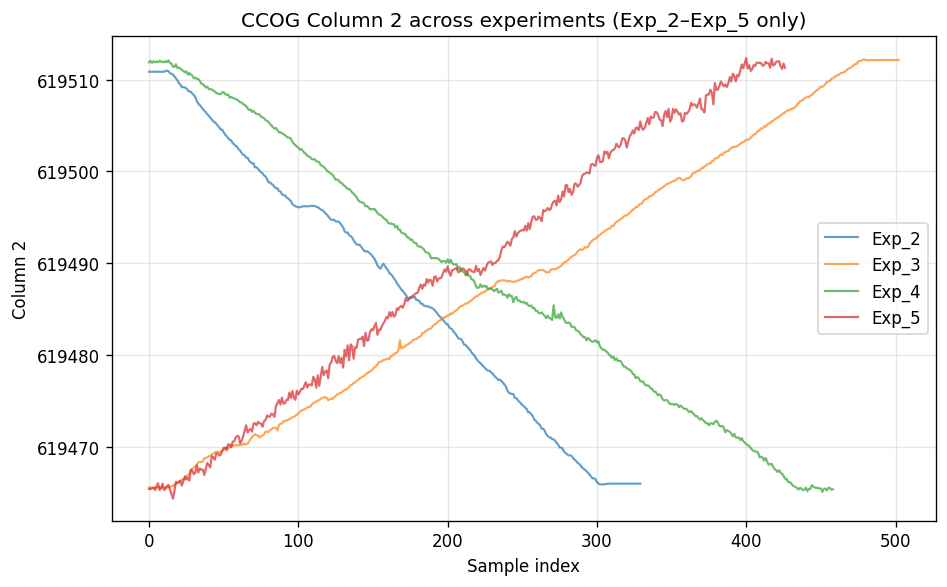

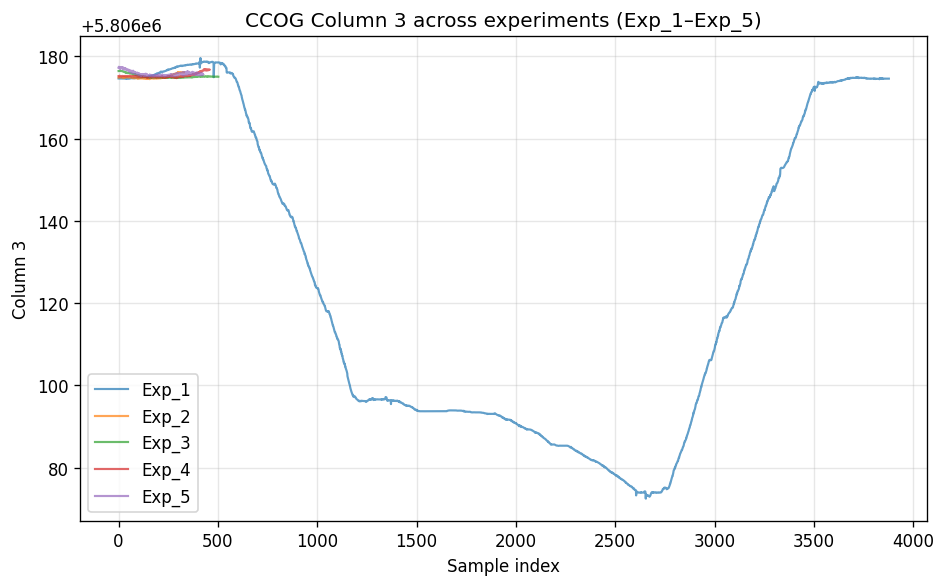

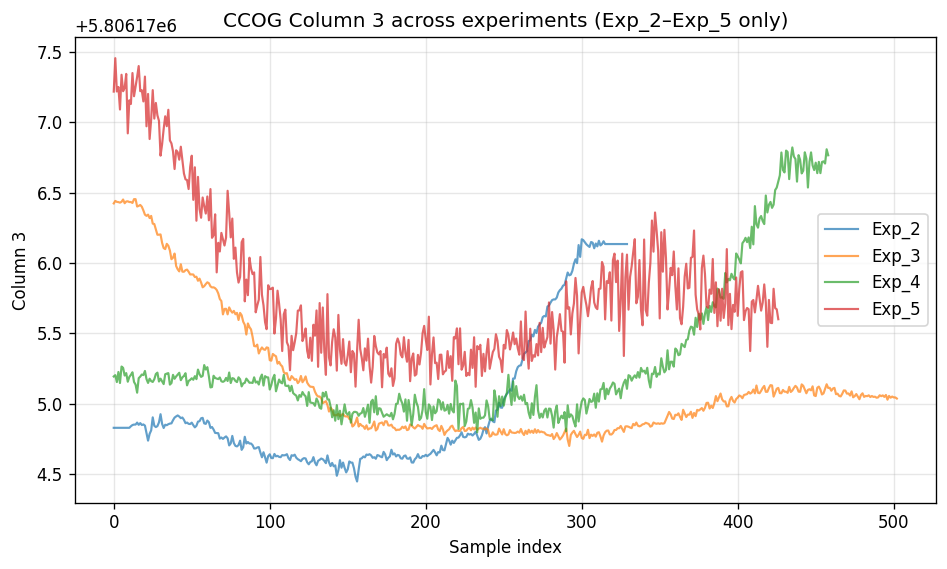

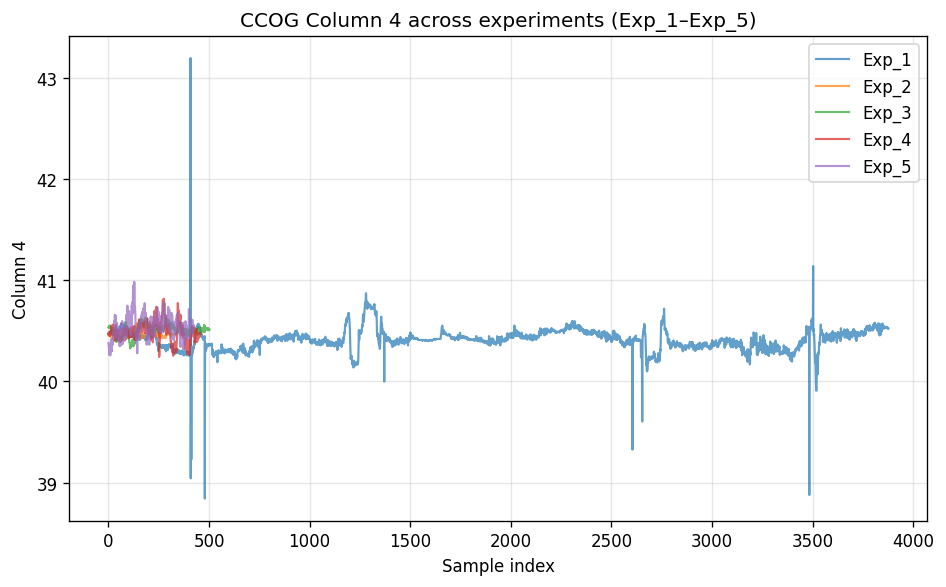

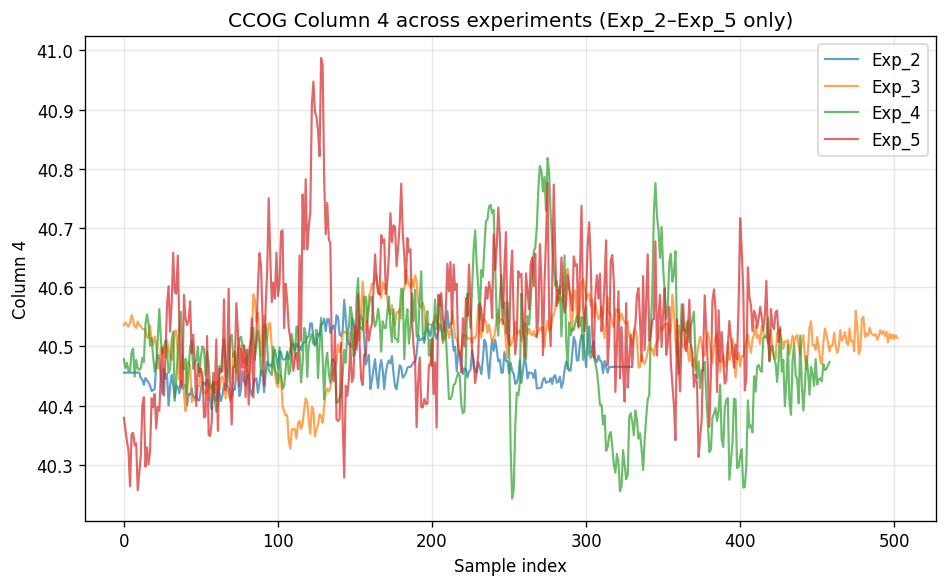

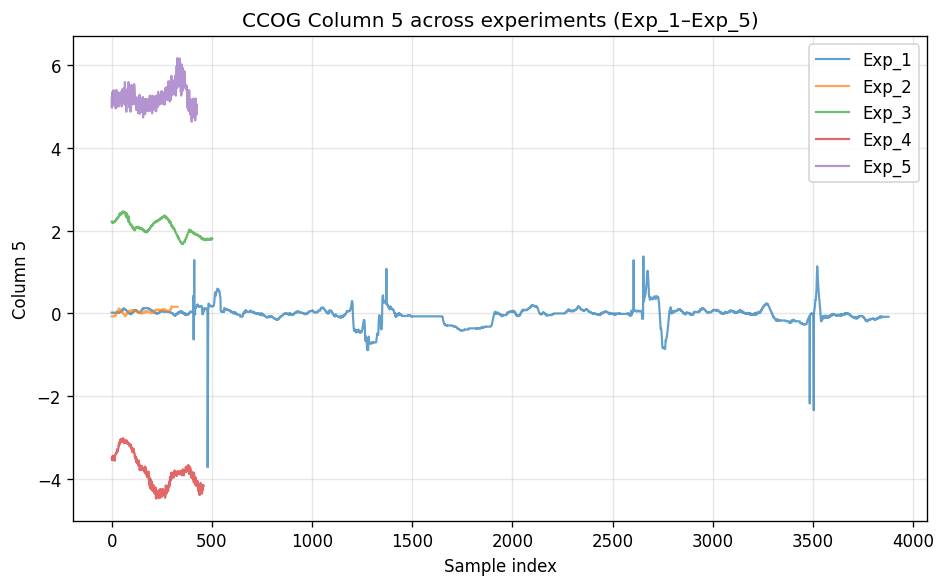

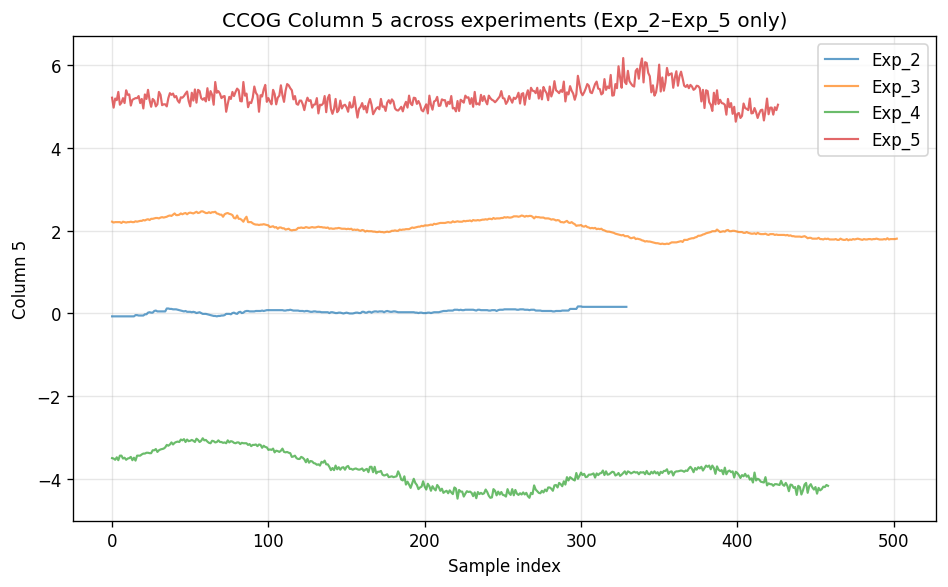

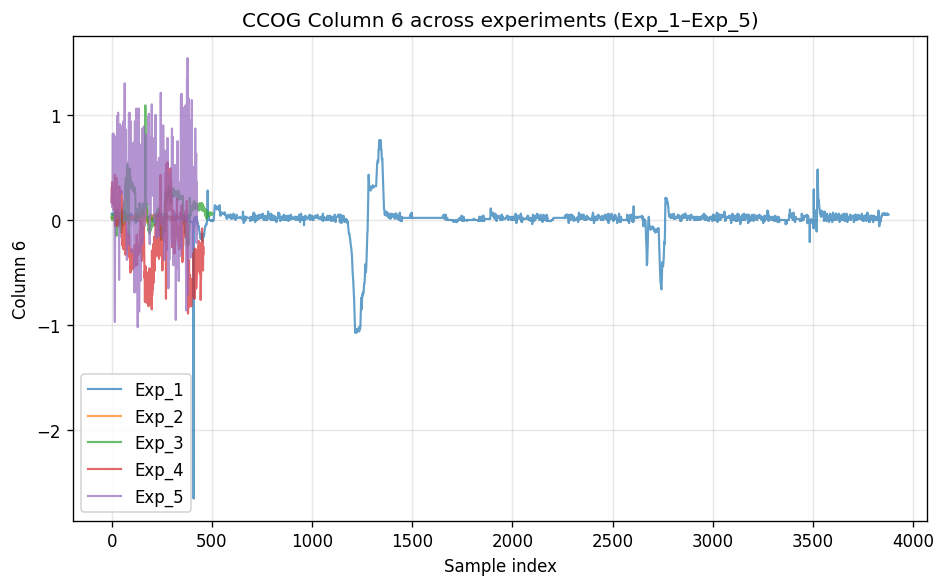

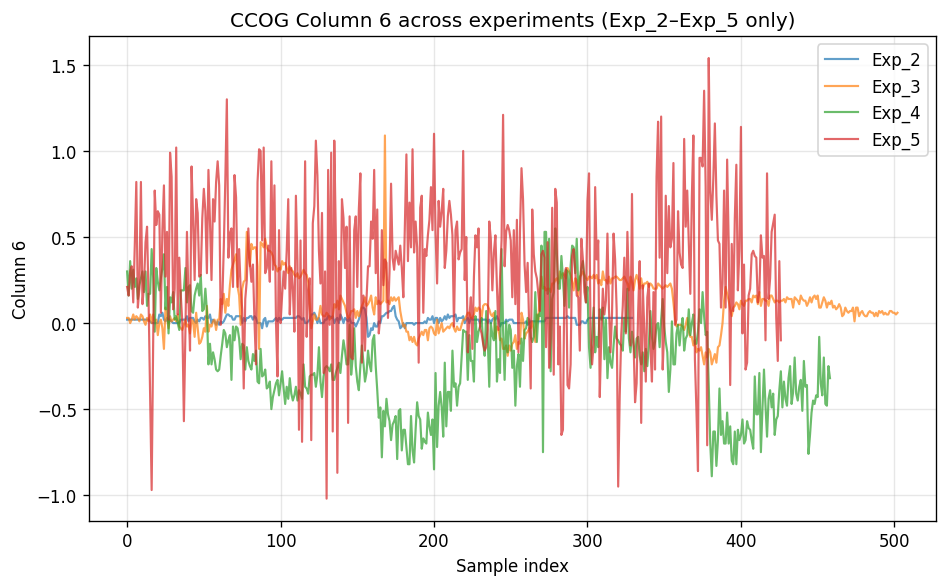

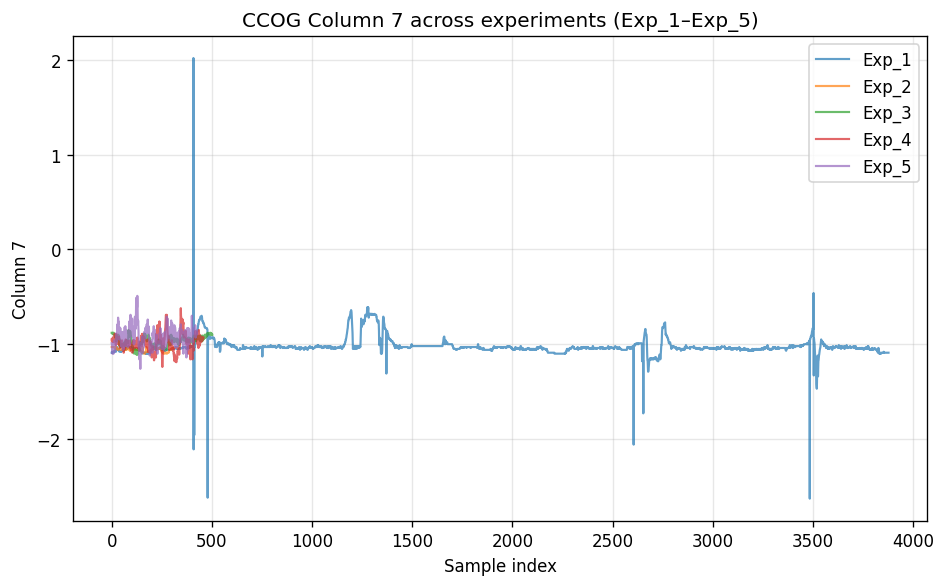

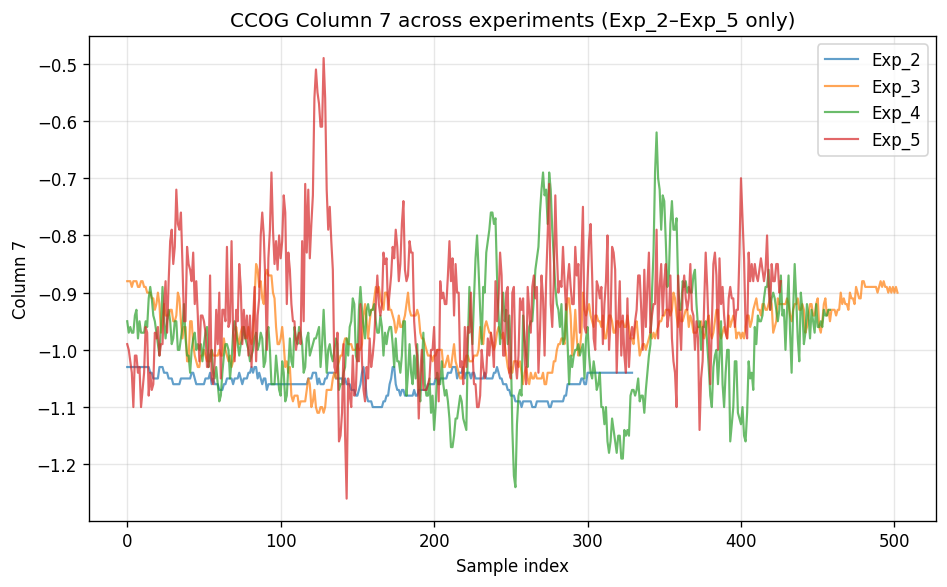

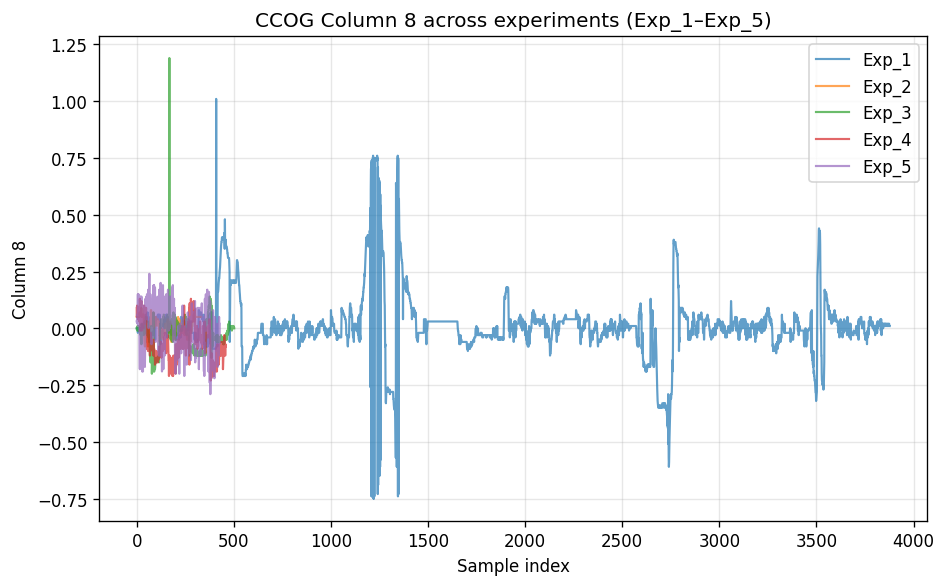

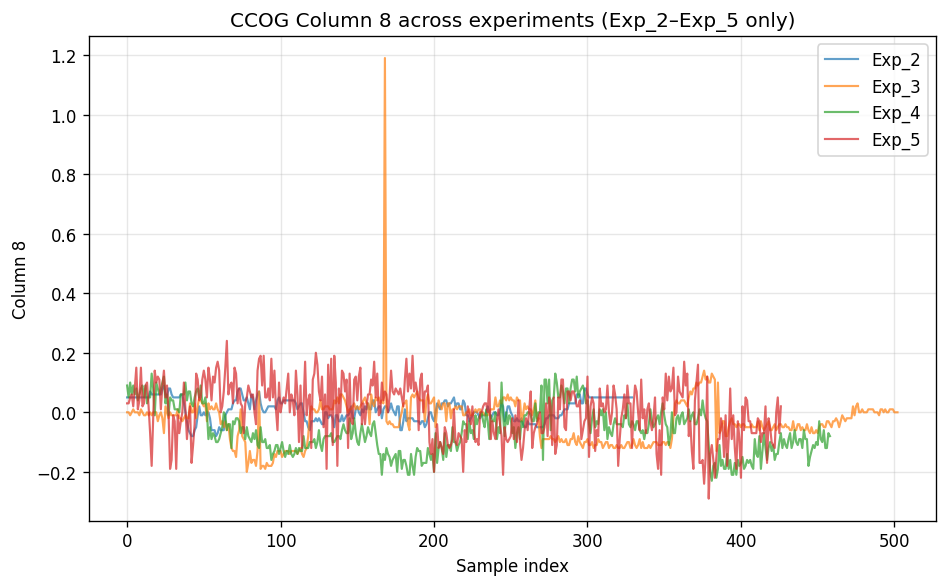

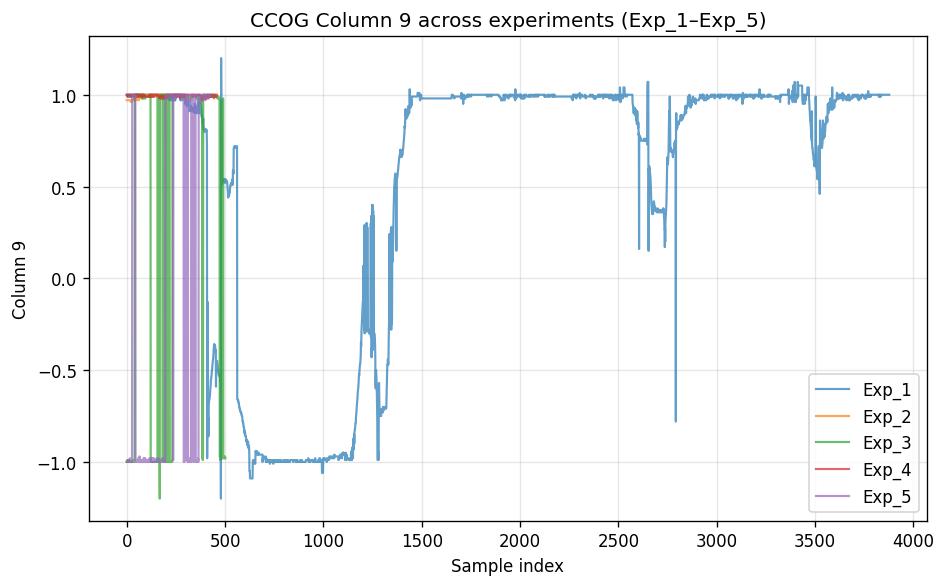

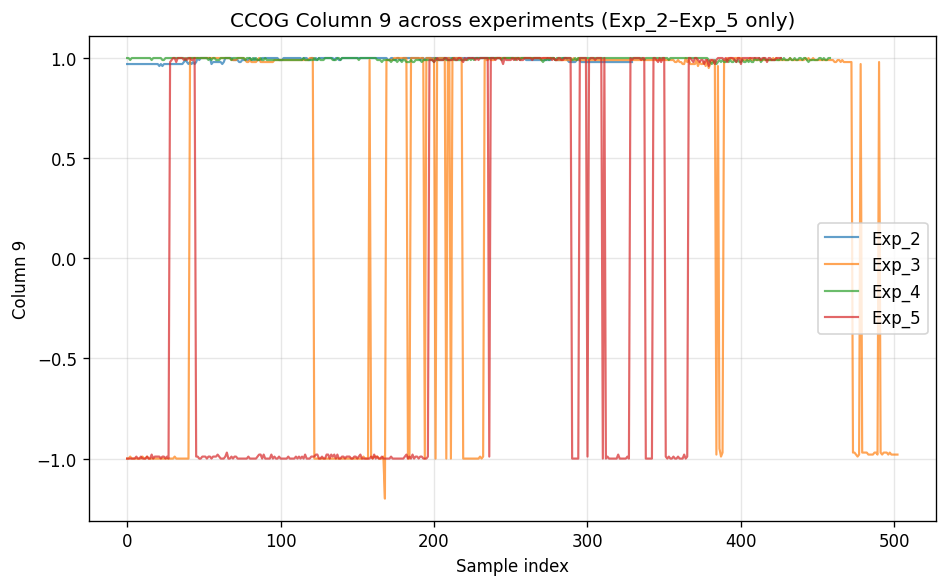

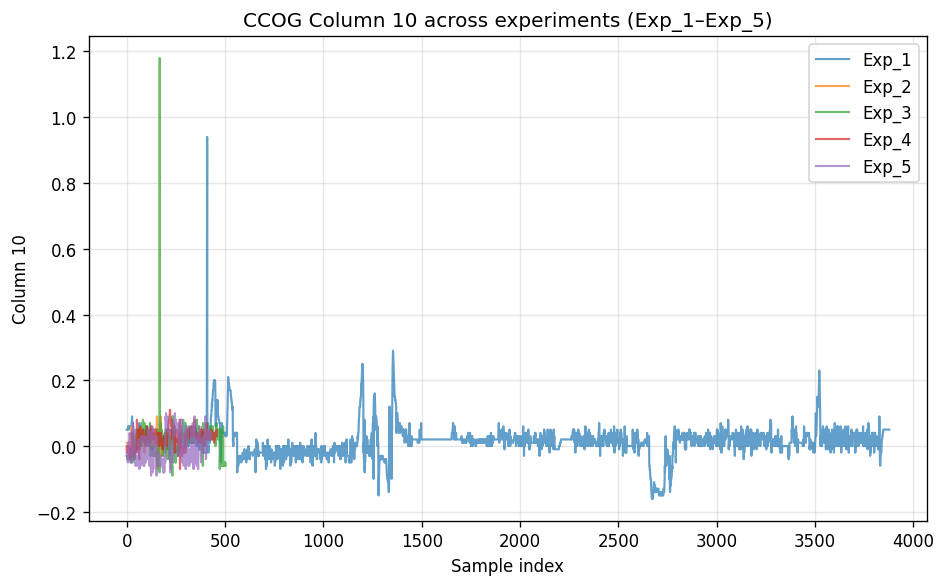

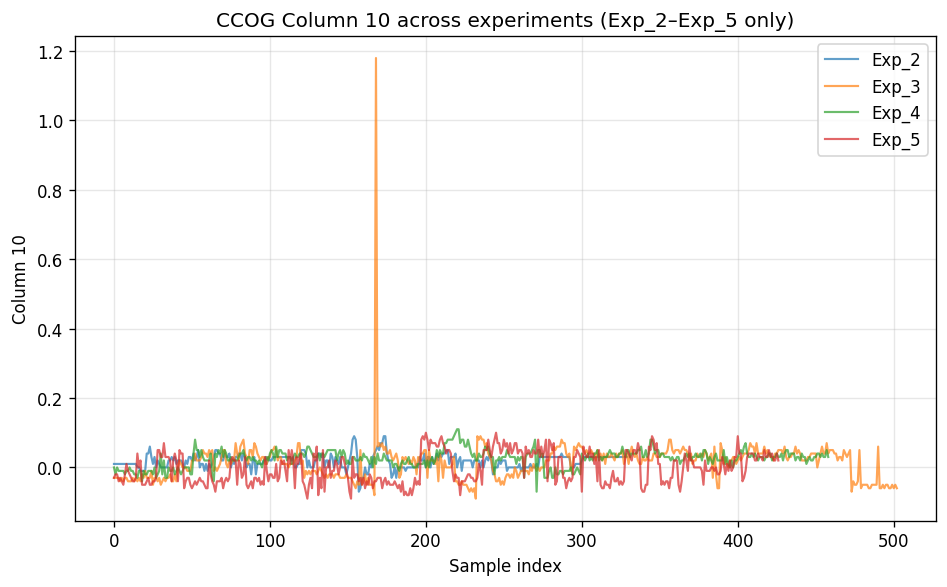

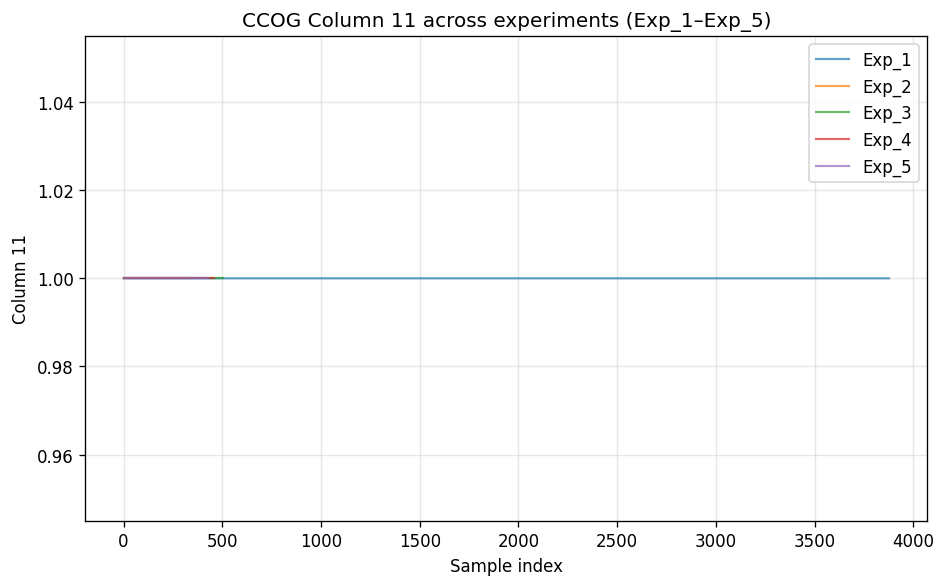

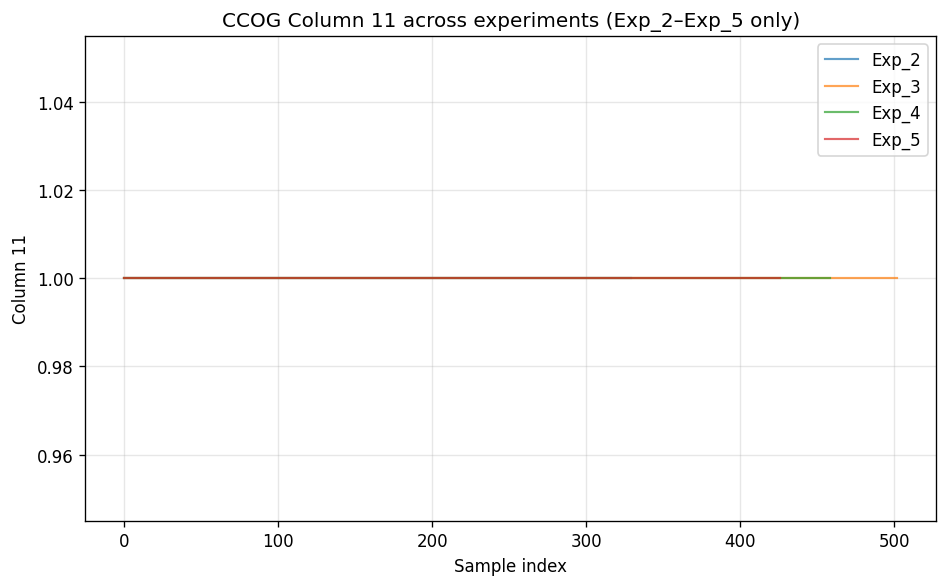

In [12]:
# choose which experiments to include
all_exps  = ["Exp_1", "Exp_2", "Exp_3", "Exp_4", "Exp_5"]
good_exps = ["Exp_2", "Exp_3", "Exp_4", "Exp_5"]  # exclude Exp_1


def plot_ccog_column_across_experiments(ccog_dict, exps, col_idx, title_suffix=""):
    """
    Plot the same CCOG column across multiple experiments.

    ccog_dict : dict like {"Exp_1": df1, ...}
    exps      : list of experiment keys to plot
    col_idx   : integer column index
    """
    plt.figure(figsize=(8, 5))

    for exp in exps:
        df = ccog_dict[exp]
        y  = df.iloc[:, col_idx].values
        x  = np.arange(len(y))
        plt.plot(x, y, label=exp, alpha=0.7, linewidth=1.3)

    plt.xlabel("Sample index")
    plt.ylabel(f"Column {col_idx}")
    plt.title(f"CCOG Column {col_idx} across experiments {title_suffix}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ─────────────────────────────────────────────────────────
# Loop over all columns and make two plots per column:
#   1) all experiments
#   2) only Exp_2–Exp_5 (exclude Exp_1)
# ─────────────────────────────────────────────────────────

# assuming all CCOG dfs have same number of columns as Exp_2
n_cols_ccog = ccog_clean["Exp_2"].shape[1]

for col_idx in range(n_cols_ccog):
    # 1) with Exp_1
    plot_ccog_column_across_experiments(
        ccog_clean, all_exps, col_idx, title_suffix="(Exp_1–Exp_5)"
    )

    # 2) without Exp_1
    plot_ccog_column_across_experiments(
        ccog_clean, good_exps, col_idx, title_suffix="(Exp_2–Exp_5 only)"
    )

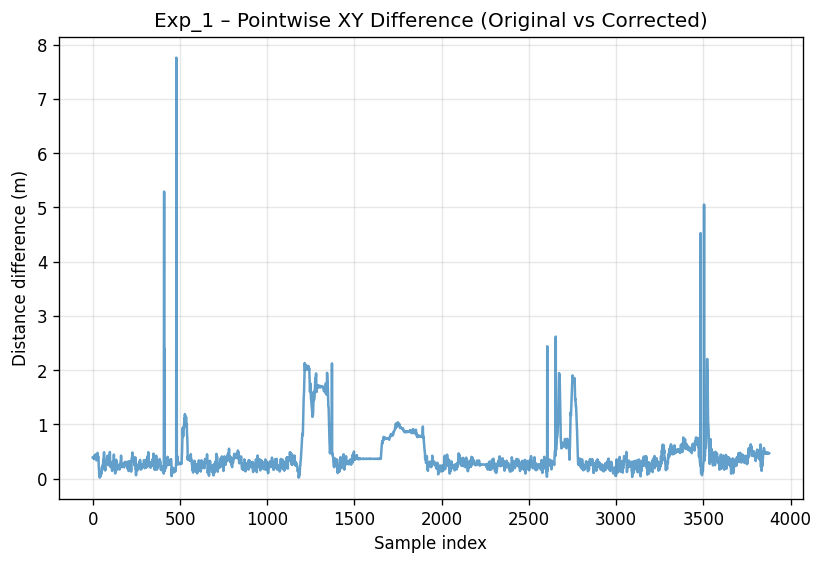

Exp_1 difference stats:
  mean: 0.4358 m
  std:  0.4101 m
  max:  7.7601 m



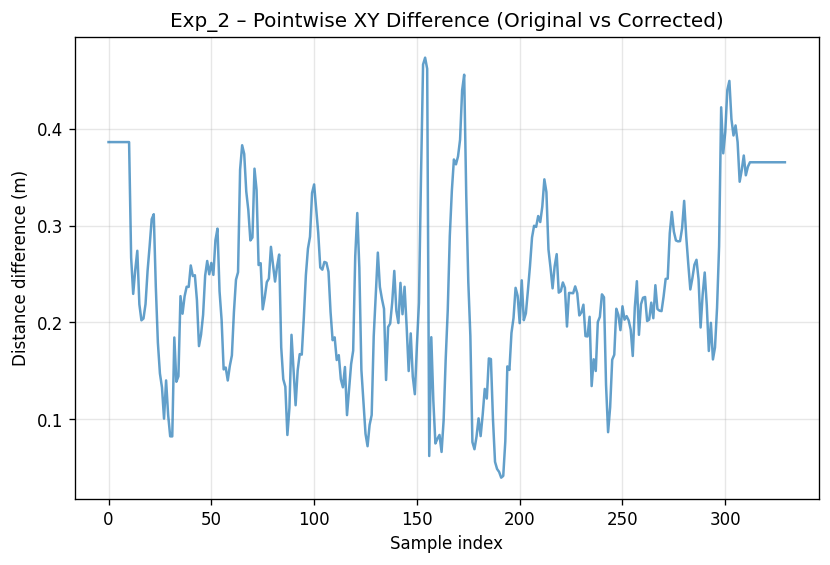

Exp_2 difference stats:
  mean: 0.2369 m
  std:  0.0918 m
  max:  0.4735 m



In [13]:
def compare_original_corrected(ccog_orig, ccog_corr, exp_name):
    x_orig = ccog_orig.iloc[:, 2].values
    y_orig = ccog_orig.iloc[:, 3].values

    x_corr = ccog_corr.iloc[:, 2].values
    y_corr = ccog_corr.iloc[:, 3].values

    # Pointwise difference
    diff = np.sqrt((x_orig - x_corr)**2 + (y_orig - y_corr)**2)

    plt.figure(figsize=(8,5))
    plt.plot(diff, alpha=0.7)
    plt.title(f"{exp_name} – Pointwise XY Difference (Original vs Corrected)")
    plt.xlabel("Sample index")
    plt.ylabel("Distance difference (m)")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"{exp_name} difference stats:")
    print(f"  mean: {diff.mean():.4f} m")
    print(f"  std:  {diff.std():.4f} m")
    print(f"  max:  {diff.max():.4f} m\n")


# Assuming you already created:
# ccog_clean["Exp_1"], ccog_corrected["Exp_1"]
# ccog_clean["Exp_2"], ccog_corrected["Exp_2"]

compare_original_corrected(ccog_clean["Exp_1"], ccog_fixed["Exp_1"], "Exp_1")
compare_original_corrected(ccog_clean["Exp_2"], ccog_fixed["Exp_2"], "Exp_2")

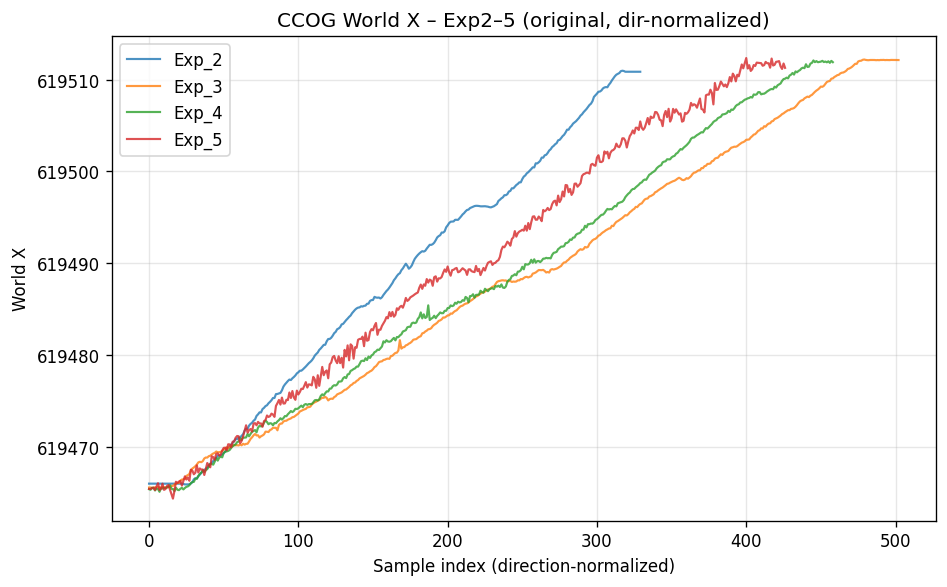

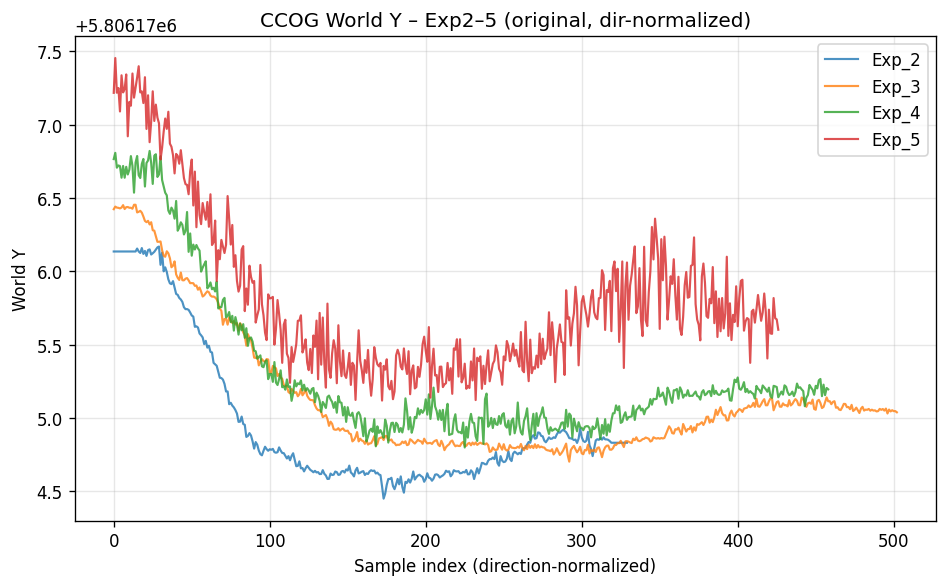

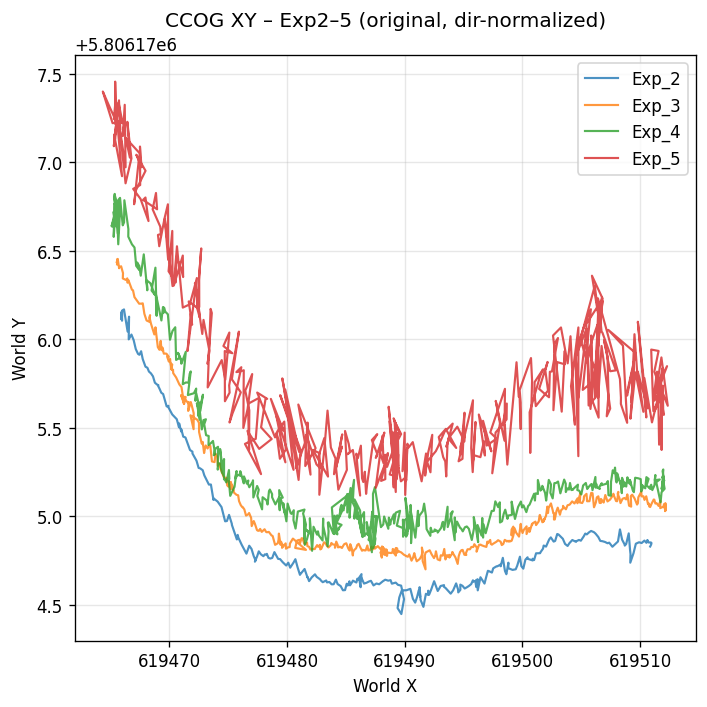

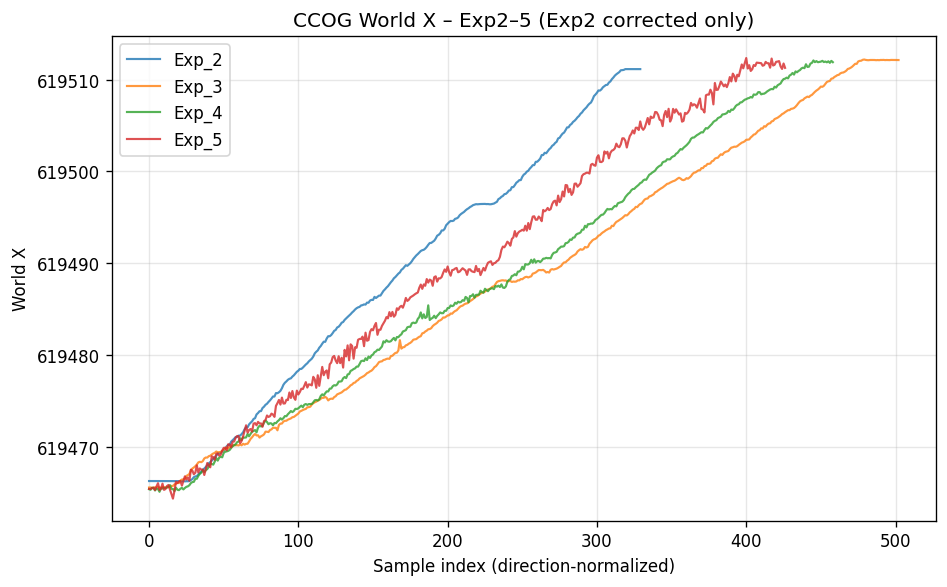

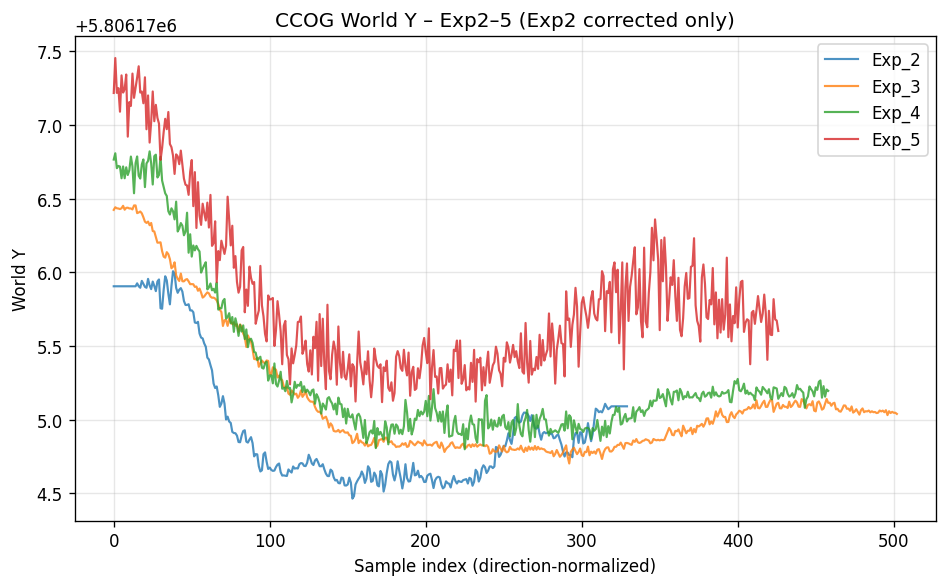

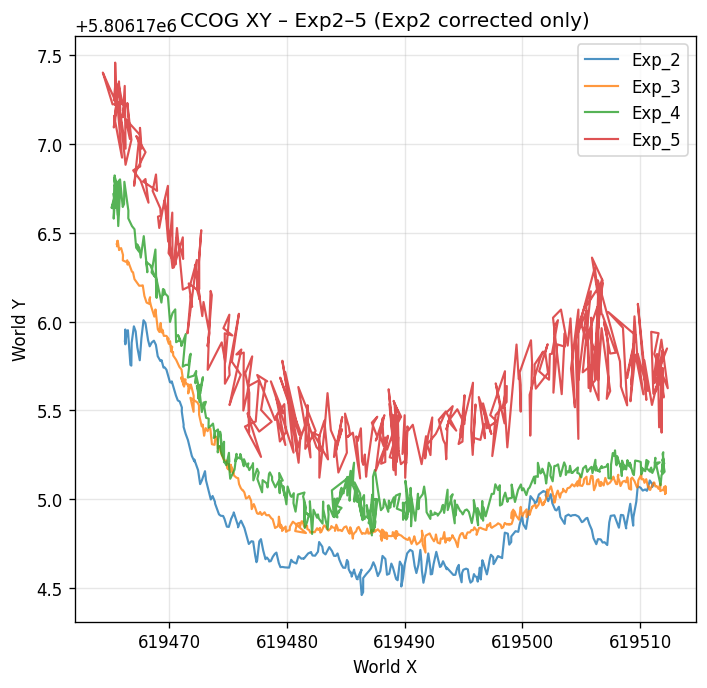

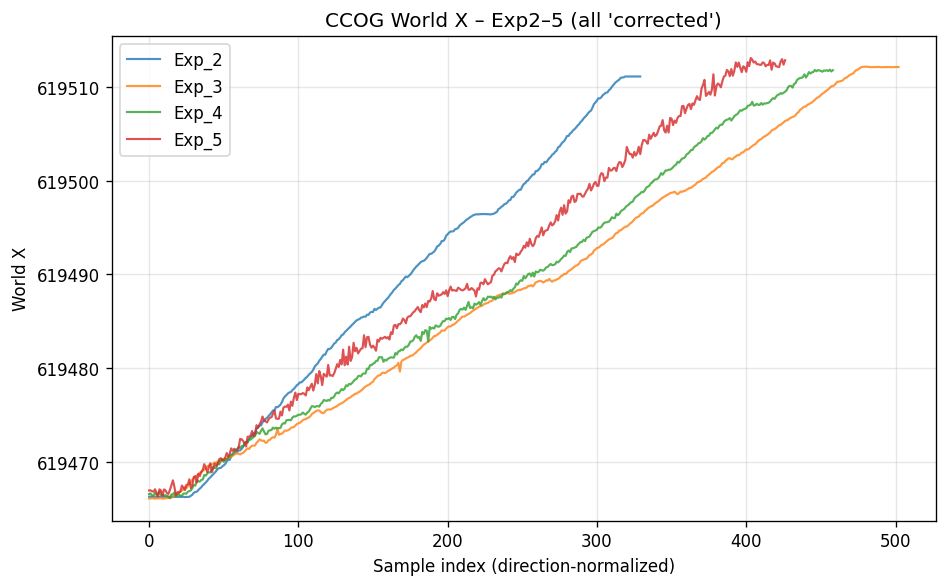

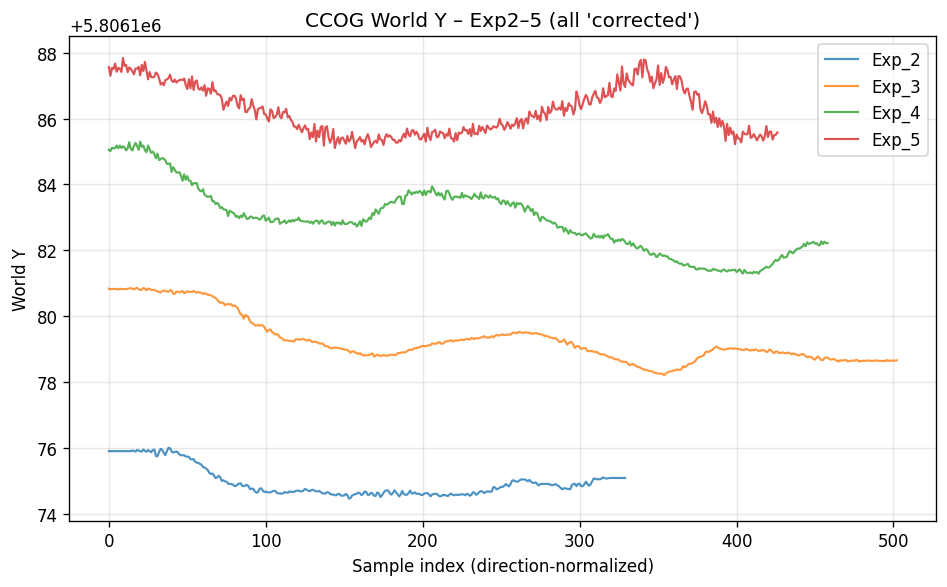

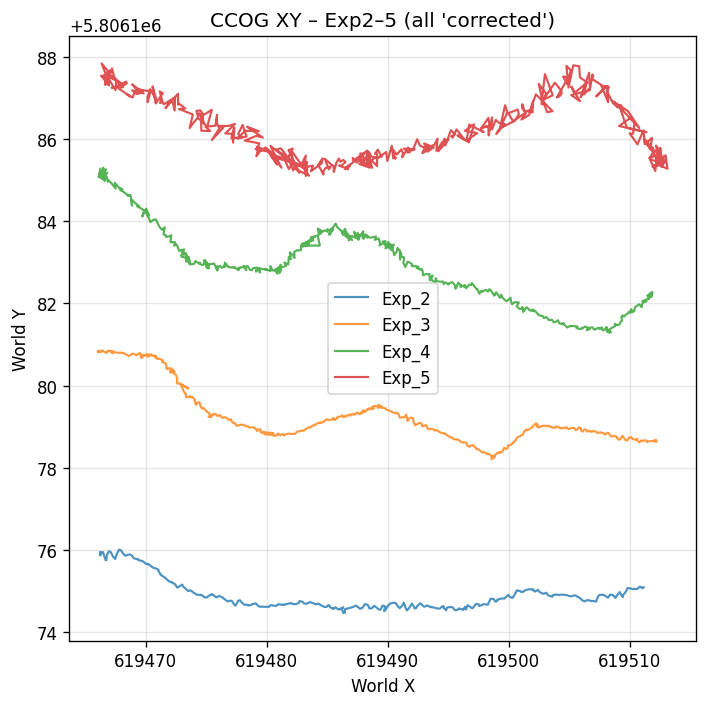

In [14]:
experiments = ["Exp_2", "Exp_3", "Exp_4", "Exp_5"]
ref_exp = "Exp_3"   # reference for direction


# ─────────────────────────────────────────────
# 1. Direction normalization (time flip)
# ─────────────────────────────────────────────

def normalize_direction_by_x(df, ref_df, x_col=2):
    """
    Flip time (row order) so that the X trend matches the reference experiment.
    """
    ref_trend = np.sign(ref_df.iloc[-1, x_col] - ref_df.iloc[0, x_col])
    cur_trend = np.sign(df.iloc[-1, x_col] - df.iloc[0, x_col])

    if ref_trend == 0 or cur_trend == 0:
        return df.reset_index(drop=True)  # degenerate case

    if cur_trend != ref_trend:
        return df.iloc[::-1].reset_index(drop=True)
    else:
        return df.reset_index(drop=True)


# direction-normalized versions of VCOG & CCOG
vcog_dir = {}
ccog_dir = {}

ref_ccog = ccog_clean[ref_exp]
ref_vcog = vcog_clean[ref_exp]

for exp in experiments:
    ccog_dir[exp] = normalize_direction_by_x(ccog_clean[exp], ref_ccog)
    vcog_dir[exp] = normalize_direction_by_x(vcog_clean[exp], ref_vcog)

# ─────────────────────────────────────────────
# 2. Heading-based "correction": 2*VCOG - CCOG
# ─────────────────────────────────────────────

def apply_heading_correction(v_df, c_df):
    """
    Reflect cable world X,Y across the cart position:
    cable_corr = 2 * cart - cable
    """
    c_corr = c_df.copy()

    vx = v_df.iloc[:, 2]
    vy = v_df.iloc[:, 3]

    cx = c_df.iloc[:, 2]
    cy = c_df.iloc[:, 3]

    c_corr.iloc[:, 2] = 2 * vx - cx  # X
    c_corr.iloc[:, 3] = 2 * vy - cy  # Y

    return c_corr

# scenario A: original (no correction)
ccog_orig = ccog_dir  # just an alias for clarity

# scenario B: only Exp_2 corrected
ccog_exp2_corr = copy.deepcopy(ccog_dir)
ccog_exp2_corr["Exp_2"] = apply_heading_correction(vcog_dir["Exp_2"],
                                                   ccog_dir["Exp_2"])

# scenario C: all Exp_2–Exp_5 corrected
ccog_all_corr = {}
for exp in experiments:
    ccog_all_corr[exp] = apply_heading_correction(vcog_dir[exp], ccog_dir[exp])

# ─────────────────────────────────────────────
# 3. Plot helpers
# ─────────────────────────────────────────────

def plot_x_all(ccog_dict, title):
    plt.figure(figsize=(8,5))
    for exp in experiments:
        df = ccog_dict[exp]
        x = df.iloc[:, 2].values
        t = np.arange(len(x))
        plt.plot(t, x, label=exp, alpha=0.8, linewidth=1.3)
    plt.xlabel("Sample index (direction-normalized)")
    plt.ylabel("World X")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_y_all(ccog_dict, title):
    plt.figure(figsize=(8,5))
    for exp in experiments:
        df = ccog_dict[exp]
        y = df.iloc[:, 3].values
        t = np.arange(len(y))
        plt.plot(t, y, label=exp, alpha=0.8, linewidth=1.3)
    plt.xlabel("Sample index (direction-normalized)")
    plt.ylabel("World Y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_xy_all(ccog_dict, title):
    plt.figure(figsize=(6,6))
    for exp in experiments:
        df = ccog_dict[exp]
        x = df.iloc[:, 2].values
        y = df.iloc[:, 3].values
        plt.plot(x, y, label=exp, alpha=0.8, linewidth=1.3)
    plt.xlabel("World X")
    plt.ylabel("World Y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ─────────────────────────────────────────────
# 4. Make the 9 plots
# ─────────────────────────────────────────────

# A) Original (only flags removed, direction normalized)
plot_x_all(ccog_orig, "CCOG World X – Exp2–5 (original, dir-normalized)")
plot_y_all(ccog_orig, "CCOG World Y – Exp2–5 (original, dir-normalized)")
plot_xy_all(ccog_orig, "CCOG XY – Exp2–5 (original, dir-normalized)")

# B) Only Exp_2 corrected
plot_x_all(ccog_exp2_corr, "CCOG World X – Exp2–5 (Exp2 corrected only)")
plot_y_all(ccog_exp2_corr, "CCOG World Y – Exp2–5 (Exp2 corrected only)")
plot_xy_all(ccog_exp2_corr, "CCOG XY – Exp2–5 (Exp2 corrected only)")

# C) All corrected
plot_x_all(ccog_all_corr, "CCOG World X – Exp2–5 (all 'corrected')")
plot_y_all(ccog_all_corr, "CCOG World Y – Exp2–5 (all 'corrected')")
plot_xy_all(ccog_all_corr, "CCOG XY – Exp2–5 (all 'corrected')")